![Cardio Image](https://sejaumdatascientist.com/wp-content/uploads/2020/09/doctor.png)
<h1><b>Cardio Catch Diseases Project by Pedro Henrique Franco Fratucci</b></h1>

# <font color=green size= 6> <b>0. BUSINESS KNOWLEDGE AND PLANNING </font></b>
***

## <font color=green size= 5>0.1 OBJECTIVE </font>
***


**<font color = red> Increase the Cardio Catch Diseases company (CCD) profit. By increase the actual tests diagnosis precision and stability. </font>**

## <font color=green size= 5>0.2 ABOUT THE ACTUAL DIAGNOSIS TEST SYSTEM </font>
***

**Data source:** <a href="https://www.kaggle.com/sulianova/cardiovascular-disease-dataset">Here</a></font>

**Business problem source:** <a href="https://sejaumdatascientist.com/projeto-de-data-science-diagnostico-precoce-de-doencas-cardiovasculares/">Here</a></font>

- Each diagnostic test costs R$ 1.000,00 for the company

- It's a manual process, with diagnostic test precision lying between 50% and 65%</h4>

- The revenue for tests with 50% precision or lower is R$ 0

- The revenue increase R$ 500 for each 5% precision above 50%</h4>

## <font color=green size= 5>0.3 SOLUTION PROPOSAL </font>
***

**Create a binary classification toll with statics model and machine learning to increase the test diagnosis recall, precision and accuracy.**

## <font color=green size= 5>0.4 RESULTS REPORTS </font>
***

- The precision and accuracy from the solution proposal

- How much profit CCD company will get by applying the solution proposal tool

- How reliable is the solution proposal tool

# <font color=green size= 6> <b>1. IMPORTS </font></b>
***


## <font color=green size= 5>1.1 LIBRARIES </font>
***

In [1]:
import inflection
import json
import pickle
import random
import requests
import warnings

import pandas                       as pd
import numpy                        as np
import matplotlib.pyplot            as plt
import seaborn                      as sns

from IPython.display               import Image
from IPython.core.display          import HTML
from boruta                        import BorutaPy
from sklearn                       import svm
from catboost                      import CatBoostClassifier
from lightgbm                      import LGBMClassifier
from sklearn.dummy                 import DummyClassifier
from sklearn.metrics               import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics               import precision_score, recall_score, f1_score, accuracy_score, cohen_kappa_score, brier_score_loss, roc_curve
from imblearn.combine              import SMOTETomek
from sklearn.ensemble              import RandomForestClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.naive_bayes           import GaussianNB
from sklearn.linear_model          import LogisticRegression, SGDClassifier
from sklearn.model_selection       import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing         import MinMaxScaler, RobustScaler
from sklearn.compose               import make_column_transformer
from sklearn.utils                 import shuffle
from sklearn.calibration           import CalibratedClassifierCV
from sklearn.feature_selection     import RFE
from xgboost                       import XGBClassifier
from scipy.stats                   import randint

%matplotlib inline

# Hide warning messages
warnings.filterwarnings('ignore')

## <font color=green size= 5>1.2 HELPER FUNCTIONS </font>
***

In [2]:
# creating a function which return the metrics for the input test and predicted arrays
def calculate_model_metrics(y_test, y_pred):
    
    # calculate precision between the arrays. Which is the percent of true positive values (y_pred) between all positive values predicted (y_pred) [TP/(P_pred)]
    precision = precision_score(y_test, y_pred)

    # calculate accuracy between the arrays. Which is the number of matchs of true positive and true negative values (y_pred) between all samples (y_pred). [(TP+TN) / (TP+TN+FP+FN)]
    accuracy = accuracy_score(y_test, y_pred)

    # calculate f1_score between the arrays. Which can be interpreted as a weighted average of the precision and recall. [(2*recall*precision) / (recall+precision)]
    f1_Score = f1_score(y_test, y_pred)

    # calculate recall between the arrays. Which is the percent of true positive values (y_pred) between all real positive values (y_test). [TP/(P_test)]
    recall = recall_score(y_test, y_pred)
    
    # calculate recall between the arrays. Which is the percent of true positive values (y_pred) between all real positive values (y_test). [TP/(P_test)]
    kappa_score = cohen_kappa_score(y_test, y_pred)
    
    return precision, accuracy, f1_Score, recall, kappa_score
    
    

# creating a function which return a metrics dataset for each model in 'classifiers' argument based on train and tests datasets arguments
def get_models_performance(x_train, x_test, y_train, y_test, models):

    # creating an empty dataframe
    df_performance = pd.DataFrame()

    for model in models:
        # printing the real model name
        print("Training " + type(model).__name__ + "...")
        # fitting the model to training data
        model.fit(x_train, y_train)

        # predicting the test dataset
        y_pred = model.predict(x_test)

        # creating model metrics
        model_precision, model_accuracy, model_f1_score, model_recall, model_kappa_score = calculate_model_metrics(y_test, y_pred)

        # creating a dict
        model_dict = {
            'model': [type(model).__name__, '---'],
            'precision': [model_precision, np.nan],
            'recall': [model_recall, np.nan],
            'f1_score': [model_f1_score, np.nan],
            'accuracy': [model_accuracy, np.nan],
            'kappa_score': [model_kappa_score, np.nan]}

        # combining the 'model_dict' as a dataframe in the initially empty 'df_performance' dataframe
        df_performance = pd.concat([df_performance, pd.DataFrame(model_dict)])

    # resetting and drop 'df_performance' dataframe index
    df_performance.reset_index(drop= True, inplace= True)

    # getting only the odd numbered rows
    rows_to_drop = np.arange(1, len(models)*2, 2)

    # droping unwanted rows that have no data
    df_performance.drop(rows_to_drop, inplace= True)

    # returning performance dataframe summary
    return df_performance



# creating a function that plots a single confusion matrix comparing test and predicted arrays
def plot_single_confusion_matrix(y_test, y_pred, model, qualifier= ""):

    # creating a confusion matrix with 'y_test' as Y axis and 'y_pred' as X axis
    cm = confusion_matrix(y_test, y_pred)

    # ploting confusion matrix as heatmap graph
    ax = sns.heatmap(cm, annot= True, fmt= 'g', cmap= 'viridis',
                             square= True, annot_kws= {"size": 15})
    # setting the figures labels
    plt.xlabel("Predicted label")
    plt.ylabel("True label")

    # setting ax title
    ax.title.set_text(type(model).__name__ + ' ' + str(qualifier))



# creating a function that plots multiple confusion matrices comparing test and predicted arrays for each model
def plot_multiple_confusion_matrices(n_rows, n_cols, x_test, y_test, models, threshold):

        # creating a figure with 'n_rows' rows and 'n_cols' columns with n_rows*n_cols axes
        fig, ax = plt.subplots(nrows= n_rows, ncols= n_cols, figsize= (15, 10))

        # returning model, with its axe and its enumerate value
        for model, ax, n in zip(models, ax.flatten(), list(range(n_rows*n_cols))):

            # predicting the test dataset probability of return for the selected model
            model_probs = model.predict_proba(x_test)

            # keep only the probabilities of getting the output as 1
            probs = pd.DataFrame(model_probs[:, 1], columns= ['prob_default'])

            # applying the threshold to rank the 'probs' dataset as class 1 or 0. Values over 'threshold' value will keep as class 1 and values below 'threshold' value will be set as class 0
            y_pred = probs['prob_default'].apply(lambda x: 
                                                1 if x > threshold else
                                                0)

            # creating a subplot for the selected model
            plt.subplot(n_rows, n_cols, n+1)

            # creating a single confusion matrix using 'plot_single_confusion_matrix' for the selected model over the subplot created
            plot_single_confusion_matrix(y_test, y_pred, model)

        # adjusting subplot
        plt.tight_layout()

        # displaying the plot
        plt.show()

## <font color=green size= 5>1.3 DATA LOAD </font>
***

In [3]:
# loading dataset
df_raw = pd.read_csv('../data/cardio_train.csv', sep= ',')

# <font color=green size= 6> <b>2. DESCRIPTIVE ANALYSIS </font></b>
***

In [4]:
# creating a dataframe's copy to work, from the original 'df_raw' dataframe
df1 = df_raw.copy()

# displaying the first 5 dataframe's registers 
df1.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## <font color=green size= 5>2.1 DATASET SUMMARY  </font>
***

- **id** - [int]: Patients ID register in the system
- **age** - [int]: Patients age in days 
- **height** - [float]: Patients height in cm
- **weight** - [float]: Patients weight in kg
- **gender** - [binary]: Patients gender
- **ap_hi** - [float]: Patients diastolic blood pressure
- **ap_lo** - [float]: Patients diastolic blood pressure
- **cholesterol** - [categorical]: Patients cholesterol level
- **gluc** - [categorical]: Patients glucose level
- **smoke** - [binary]: Check if Patients is a smoker
- **alco** - [binary]: Check if Patients is a drinker
- **active** - [binary]: Check if patients practices physical activities
- **cardio** - [binary]: Check if patients practices has cardiovascular diseases

## <font color=green size= 5>2.2 DIMENSIONS CHECK </font>
***

In [5]:
# printing the dataset's registers amounts
print(f"The dataframe 'df1' has {df1.shape[0]} registers.")

# printing the dataset's columns amounts
print(f"The dataframe 'df1' has {df1.shape[1]} columns.")

The dataframe 'df1' has 70000 registers.
The dataframe 'df1' has 13 columns.


## <font color=green size= 5>2.3 COLUMNS RENAME </font>
***

In [6]:
# creating the dataset's new columns names
new_columns = ['id', 'age', 'gender', 'height', 'weight', 'high_pressure', 'low_pressure', 'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio_disease']

# changing the dataset's columns names for the 'new_columns' list values       
df1.columns = new_columns

# displaying the first 5 dataframe's registers
df1.head()

,id,age,gender,height,weight,high_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio_disease
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## <font color=green size= 5>2.4 DATA TYPES CHECK </font>
***

In [7]:
# checking the dataset's columns registers type values
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              70000 non-null  int64  
 1   age             70000 non-null  int64  
 2   gender          70000 non-null  int64  
 3   height          70000 non-null  int64  
 4   weight          70000 non-null  float64
 5   high_pressure   70000 non-null  int64  
 6   low_pressure    70000 non-null  int64  
 7   cholesterol     70000 non-null  int64  
 8   glucose         70000 non-null  int64  
 9   smoker          70000 non-null  int64  
 10  alcohol         70000 non-null  int64  
 11  active          70000 non-null  int64  
 12  cardio_disease  70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


***
**As seen above:**

Columns types are the expected ones.

## <font color=green size= 5>2.5 MISSING DATA CHECK </font>
***

In [8]:
# checking the dataset's columns NaN values 
df1.isna().sum()

id                0
age               0
gender            0
height            0
weight            0
high_pressure     0
low_pressure      0
cholesterol       0
glucose           0
smoker            0
alcohol           0
active            0
cardio_disease    0
dtype: int64

***
**As seen above:**

There are no NaN values at all in the dataset.

## <font color=green size= 5>2.6 DATA STATISTICAL DESCRIPTION </font>
***

In [9]:
# creating a dataset with only numerical features from the 'df1' dataset
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])

# creating a dataset with only categorical features from the 'df1' dataset
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64'])

In [10]:
# calculating the central tendency value - mean
ct1 = pd.DataFrame(np.round(num_attributes.apply(np.mean), 2)).T

# calcultating the central tendency value - median
ct2 = pd.DataFrame(np.round(num_attributes.apply(np.median), 2)).T


# calcultating the dispersion value - std
d1 = pd.DataFrame(np.round(num_attributes.apply(np.std))).T

# calcultating the dispersion value - min
d2 = pd.DataFrame(np.round(num_attributes.apply(min))).T

# calcultating the dispersion value - max
d3 = pd.DataFrame(np.round(num_attributes.apply(max))).T

# calcultating the dispersion value - range
d4 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.max() - x.min()))).T

# calcultating the dispersion value - kurtosis
d5 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.skew()),2)).T

# calcultating the dispersion value - std
d6 = pd.DataFrame(np.round(num_attributes.apply(lambda x: x.kurtosis()),2)).T


# concatenating the calculated values above in a dataset named 'df1_statistical'
df1_statistical = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# inserting the 'df1_statistical' columns names
df1_statistical.columns = ['column', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

# displaying the 'df1_statistical' dataset
df1_statistical

,column,min,max,range,mean,median,std,skew,kurtosis
0,id,0.0,99999.0,99999.0,49972.42,50001.5,28851.0,-0.00,-1.20
1,age,10798.0,23713.0,12915.0,19468.87,19703.0,2467.0,-0.31,-0.82
2,gender,1.0,2.0,1.0,1.35,1.0,0.0,0.63,-1.60
3,height,55.0,250.0,195.0,164.36,165.0,8.0,-0.64,7.94
4,weight,10.0,200.0,190.0,74.21,72.0,14.0,1.01,2.59
5,high_pressure,-150.0,16020.0,16170.0,128.82,120.0,154.0,85.30,7580.07
6,low_pressure,-70.0,11000.0,11070.0,96.63,80.0,188.0,32.11,1425.91
7,cholesterol,1.0,3.0,2.0,1.37,1.0,1.0,1.59,0.99
8,glucose,1.0,3.0,2.0,1.23,1.0,1.0,2.40,4.29
9,smoker,0.0,1.0,1.0,0.09,0.0,0.0,2.91,6.44


***
**As seen above:**

- **'high_pressure'** column with negative values
- **'low_pressure'** column with negative values
- **'high_pressure'** column with -150mmHg minimum value and 16020mmHg maximum value with a mean value approximately 128mmHg
- **'low_pressure'** column with -70mmHg minimum value and 11070mmHg maximum value with a mean value approximately 96mmHg
- **'weight'** column with 10kg minimum value and 200kg maximum value with a mean value approximately 74kg
- **'height'** column with 55cm minimum value and 250cm maximum value with a mean value approximately 164cm
- **'age'** column is in days, not in years

# <font color=green size= 6> <b>3. FEATURES ENGINEERING </font></b>
***

In [11]:
# creating a dataframe's copy to work, from the original 'df1' dataframe
df2 = df1.copy()

# displaying the first 5 dataframe's registers 
df2.head()

,id,age,gender,height,weight,high_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio_disease
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## <font color=green size= 5>3.1 MIND MAP AND HYPOTESES </font>
***

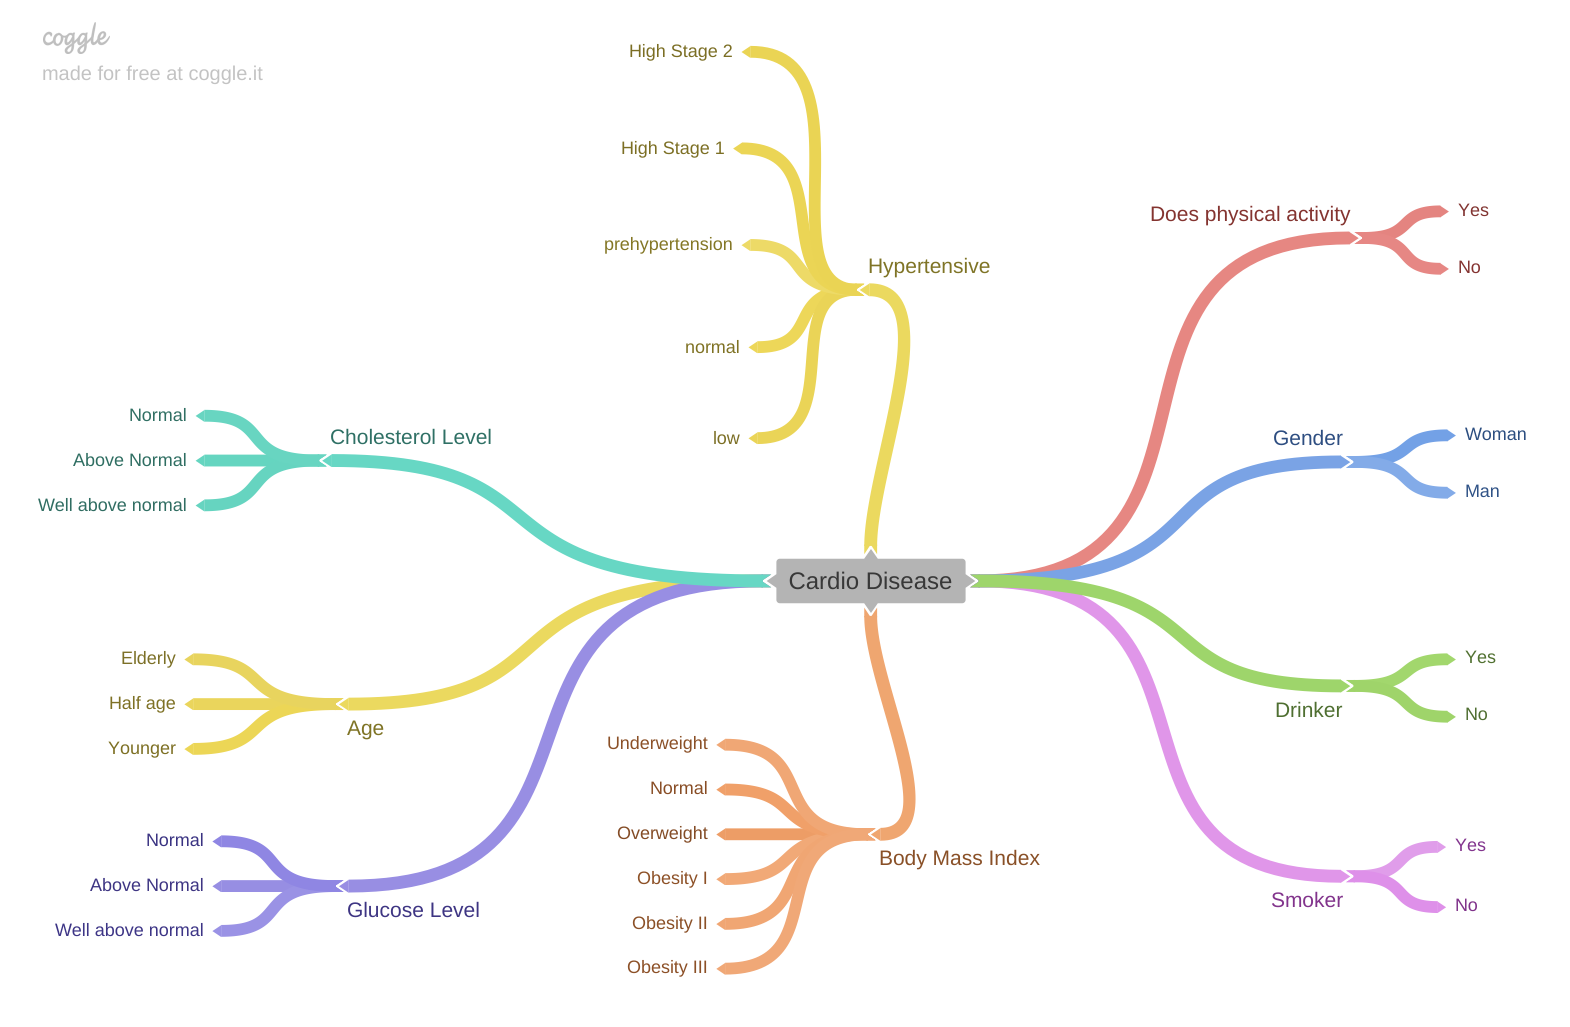

In [12]:
Image('../images/mind_map.png')

- **HYPOTESE 1 (H1):** Chances of having Heart diseases increases by being a man 

- **HYPOTESE 2 (H2):** Chances of having Heart diseases increases by increase the Body Mass Index 

- **HYPOTESE 3 (H3):** Chances of having Heart diseases increases by increase the Cholesterol level 

- **HYPOTESE 4 (H4):** Chances of having Heart diseases increases by increase the Glucose level 

- **HYPOTESE 5 (H5):** Chances of having Heart diseases increases by being a smoker

- **HYPOTESE 6 (H6):** Chances of having Heart diseases increases by intake alcohol through life 

- **HYPOTESE 7 (H7):** Chances of having Heart diseases decreases by being an active person through life

- **HYPOTESE 8 (H8):** Chances of having Heart diseases increases by being an older person

- **HYPOTESE 9 (H9):** Chances of having Heart diseases increases by being hypertensive person 

- **HYPOTESE 10 (H10):** Chances of having Heart diseases is higher between hypertensive elderly people than general hypertensive people

## <font color=green size= 5>3.2 FEATURES TRANSFORMATION </font>
***

In [13]:
# creating an array with the dataset's 'height' column values in meters
height_cm = df2['height'].values / 100

# creating a dataset's column with the Body Mass Index values
df2['BMI'] = df2['weight'].values / height_cm**2

# creating a dataset's column with the Body Mass Index level values
df2['BMI_level'] = df2['BMI'].apply(lambda x: 
                                              1 if x < 18.5 else
                                              2 if x >  18.5 and x < 25.0 else
                                              3 if x >= 25.0 and x < 30.0 else
                                              4 if x >= 30.0 and x < 35.0 else
                                              5 if x >= 35.0 and x < 40.0 else
                                              6)

# modifying the dataset's 'age' column values to years
df2['age'] = round(df2['age']/365, ndigits= 0).astype(int)


# creating a dataset's column with the age level values
df2['age_range'] = df2['age'].apply(lambda x: 
                                              1 if x < 18 else
                                              2 if x >= 18 and x < 60 else
                                              3 )
                                    
# creating a dataset's column with the hypertension level values
df2['hypertension_level'] = df2.apply(lambda x: 
                                              1 if (40 >= x['high_pressure'] < 90) and (40 >= x['low_pressure'] < 60) else
                                              2 if (90 >= x['high_pressure'] < 120) and (60 >= x['low_pressure'] < 80) else
                                              3 if (120 >= x['high_pressure'] < 130) and (80 >= x['low_pressure'] < 85) else
                                              4 if (130 >= x['high_pressure'] <= 140) and (85 >= x['low_pressure'] <= 90) else
                                              5 if (x['high_pressure'] > 140) and (x['low_pressure'] > 90) else
                                              5, axis= 1)

In [14]:
# removing the unnecessaries dataset's columns
df2.drop(columns= ['id'], inplace= True)

# displaying the first 5 dataframe's registers
df2.head()

,age,gender,height,weight,high_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio_disease,BMI,BMI_level,age_range,hypertension_level
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,2,2,3
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,2,5
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,2,2,4
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,3,2,5
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,2,2,3


## <font color=green size= 5>3.3 OUTLIERS MANIPULATION </font>
***

**We will treat all keypoints pointed at section 2.6.**

### <font color=green size= 4>3.3.1 HIGH AND LOW PRESSURE VALUES OUTLIERS </font>
***

- For outliers values, it will be considered the boundaries defined by this Medical Source: <a href="https://www.medicalnewstoday.com/articles/327178#categories">Here</a></font>

- For invalid values, as mentioned in section 2.6, it will be considered the negative values.

In [15]:
# removing the 'high_pressure' and 'low_pressure' columns outliers and invalid values from 'df2' dataset

df2 = df2[ ~ 
          ((df2['high_pressure'] < 40)
              | (df2['high_pressure'] > 180)
              | (df2['low_pressure'] < 40)
              | (df2['low_pressure'] > 120))]

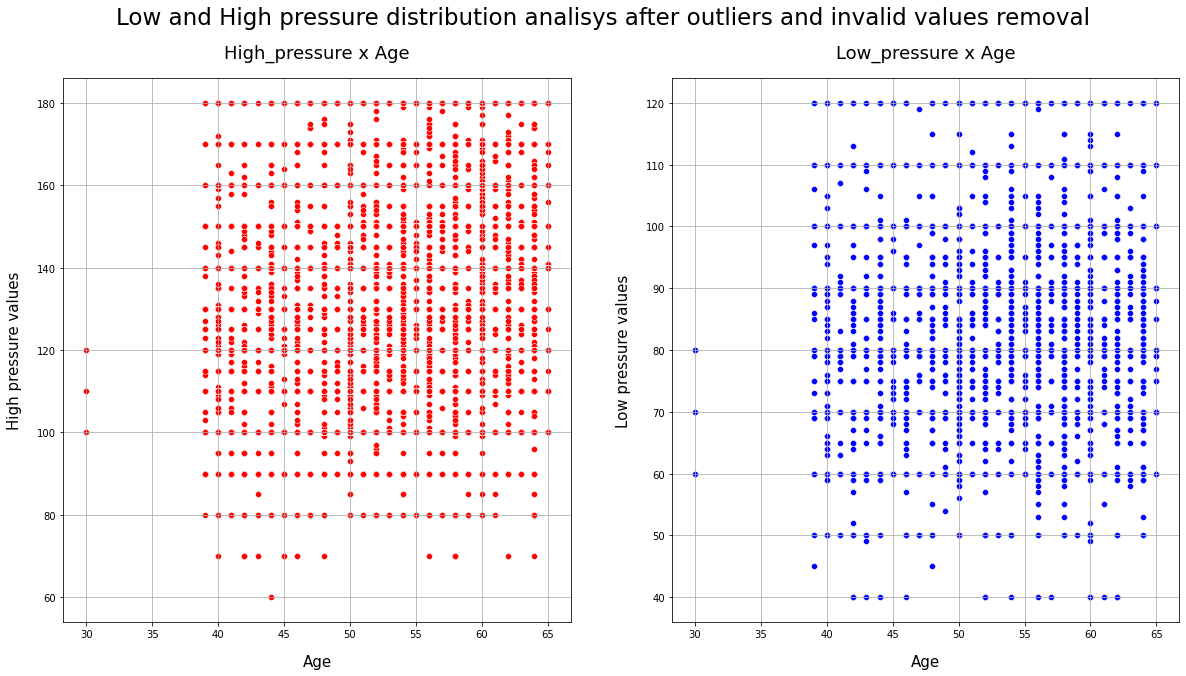

In [16]:
# creating a figure with 2 horizontal axis
fig, axes = plt.subplots(1, 2, figsize= (20, 10))

# setting the figure title and size
fig.suptitle('Low and High pressure distribution analisys after outliers and invalid values removal', size= 23)

# setting first axes graph, title and labels
sns.scatterplot(ax= axes[0], x= df2['age'], y=df2['high_pressure'], color= 'r')
axes[0].set_title('High_pressure x Age', size= 18, pad= 20)
axes[0].set_xlabel('Age', size= 15, labelpad= 15)
axes[0].set_ylabel('High pressure values', size= 15, labelpad= 15)
axes[0].grid()

# setting second axes graph, title and labels
sns.scatterplot(ax= axes[1], x= df2['age'], y= df2['low_pressure'], color= 'b')
axes[1].set_title('Low_pressure x Age', size= 18, pad= 20)
axes[1].set_xlabel('Age', size= 15, labelpad= 15)
axes[1].set_ylabel('Low pressure values', size= 15, labelpad= 15)
axes[1].grid()

### <font color=green size= 4>3.3.2 WEIGHT AND HEIGHT OUTLIERS </font>
***

For outliers values, it will be considered the values shown in the boxplot and distribution graphs.

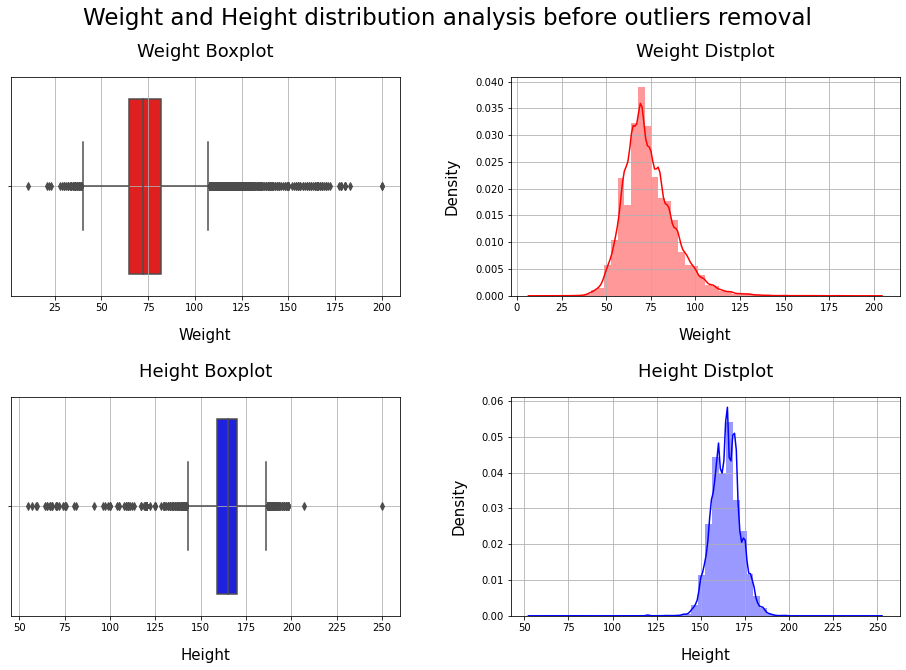

In [17]:
# creating a figure with 2 horizontal axis
fig, axes = plt.subplots(2, 2, figsize= (15, 10))
fig.tight_layout(pad= 8)

# setting the figure title and size
fig.suptitle('Weight and Height distribution analysis before outliers removal', size=23)

# setting first axes graph, title and labels
sns.boxplot(ax= axes[0,0], x= df2['weight'], color= 'r')
axes[0,0].set_title('Weight Boxplot', size= 18, pad= 20)
axes[0,0].set_xlabel('Weight', size= 15, labelpad= 15)
axes[0,0].grid()

# setting first axes graph, title and labels
sns.distplot(ax= axes[0,1], x= df2['weight'], color= 'r')
axes[0,1].set_title('Weight Distplot', size= 18, pad= 20)
axes[0,1].set_xlabel('Weight', size= 15, labelpad= 15)
axes[0,1].set_ylabel('Density', size= 15, labelpad= 15)
axes[0,1].grid()

# setting first axes graph, title and labels
sns.boxplot(ax= axes[1,0], x= df2['height'], color= 'b')
axes[1,0].set_title('Height Boxplot', size= 18, pad= 20)
axes[1,0].set_xlabel('Height', size= 15, labelpad= 15)
axes[1,0].grid()

# setting first axes graph, title and labels
sns.distplot(ax= axes[1,1], x= df2['height'], color= 'b')
axes[1,1].set_title('Height Distplot', size= 18, pad= 20)
axes[1,1].set_xlabel('Height', size= 15, labelpad= 15)
axes[1,1].set_ylabel('Density', size= 15, labelpad= 15)
axes[1,1].grid()

***
**As seen above:**
<br>
<br>

**'weight' feature outliers:**
- Values lower than 30 kg
- Values higher then 170 kg

**'height' feature outliers:**
- Values lower than 110 cm
- Values higher then 200 cm

In [18]:
# removing the 'height' and 'weight' columns outliers from 'df2' dataset
df2 = df2[ ~ 
          ((df2['weight'] < 30)
              | (df2['weight'] > 170)
              | (df2['height'] < 110)
              | (df2['height'] > 200))]

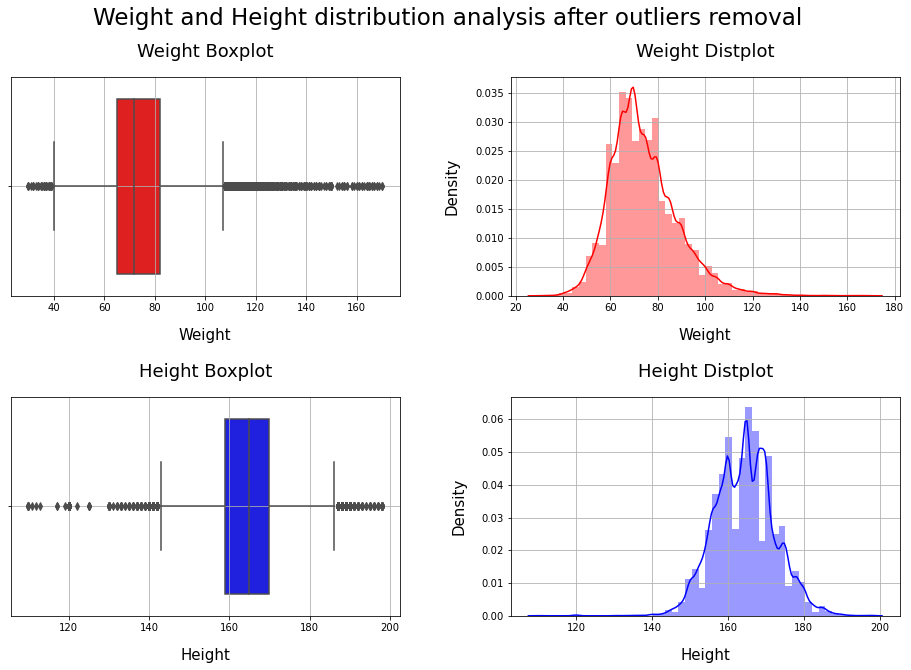

In [19]:
# creating a figure with 2 horizontal axis
fig, axes = plt.subplots(2, 2, figsize= (15, 10))
fig.tight_layout(pad= 8)

# setting the figure title and size
fig.suptitle('Weight and Height distribution analysis after outliers removal', size=23)

# set first axes graph, title and labels
sns.boxplot(ax= axes[0,0], x= df2['weight'], color= 'r')
axes[0,0].set_title('Weight Boxplot', size= 18, pad= 20)
axes[0,0].set_xlabel('Weight', size= 15, labelpad= 15)
axes[0,0].grid()

# setting first axes graph, title and labels
sns.distplot(ax= axes[0,1], x= df2['weight'], color= 'r')
axes[0,1].set_title('Weight Distplot', size= 18, pad= 20)
axes[0,1].set_xlabel('Weight', size= 15, labelpad= 15)
axes[0,1].set_ylabel('Density', size= 15, labelpad= 15)
axes[0,1].grid()

# setting first axes graph, title and labels
sns.boxplot(ax= axes[1,0], x= df2['height'], color= 'b')
axes[1,0].set_title('Height Boxplot', size= 18, pad= 20)
axes[1,0].set_xlabel('Height', size= 15, labelpad= 15)
axes[1,0].grid()

# setting first axes graph, title and labels
sns.distplot(ax= axes[1,1], x= df2['height'], color= 'b')
axes[1,1].set_title('Height Distplot', size= 18, pad= 20)
axes[1,1].set_xlabel('Height', size= 15, labelpad= 15)
axes[1,1].set_ylabel('Density', size= 15, labelpad= 15)
axes[1,1].grid()

# <font color=green size= 6> <b>4. EXPLORATORY DATA ANALYSIS </font></b>
***

In [20]:
# creating a dataframe's copy to work, from the original 'df2' dataframe
df3 = df2.copy()

# displaying the first 5 dataframe's registers 
df3.head()

,age,gender,height,weight,high_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio_disease,BMI,BMI_level,age_range,hypertension_level
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,2,2,3
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,4,2,5
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,2,2,4
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,3,2,5
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,2,2,3


## <font color=green size= 5>4.1 UNIVARIATE ANALYSIS </font>
***

### <font color=green size= 4>4.1.1 CATEGORICAL VARIABLES </font>
***

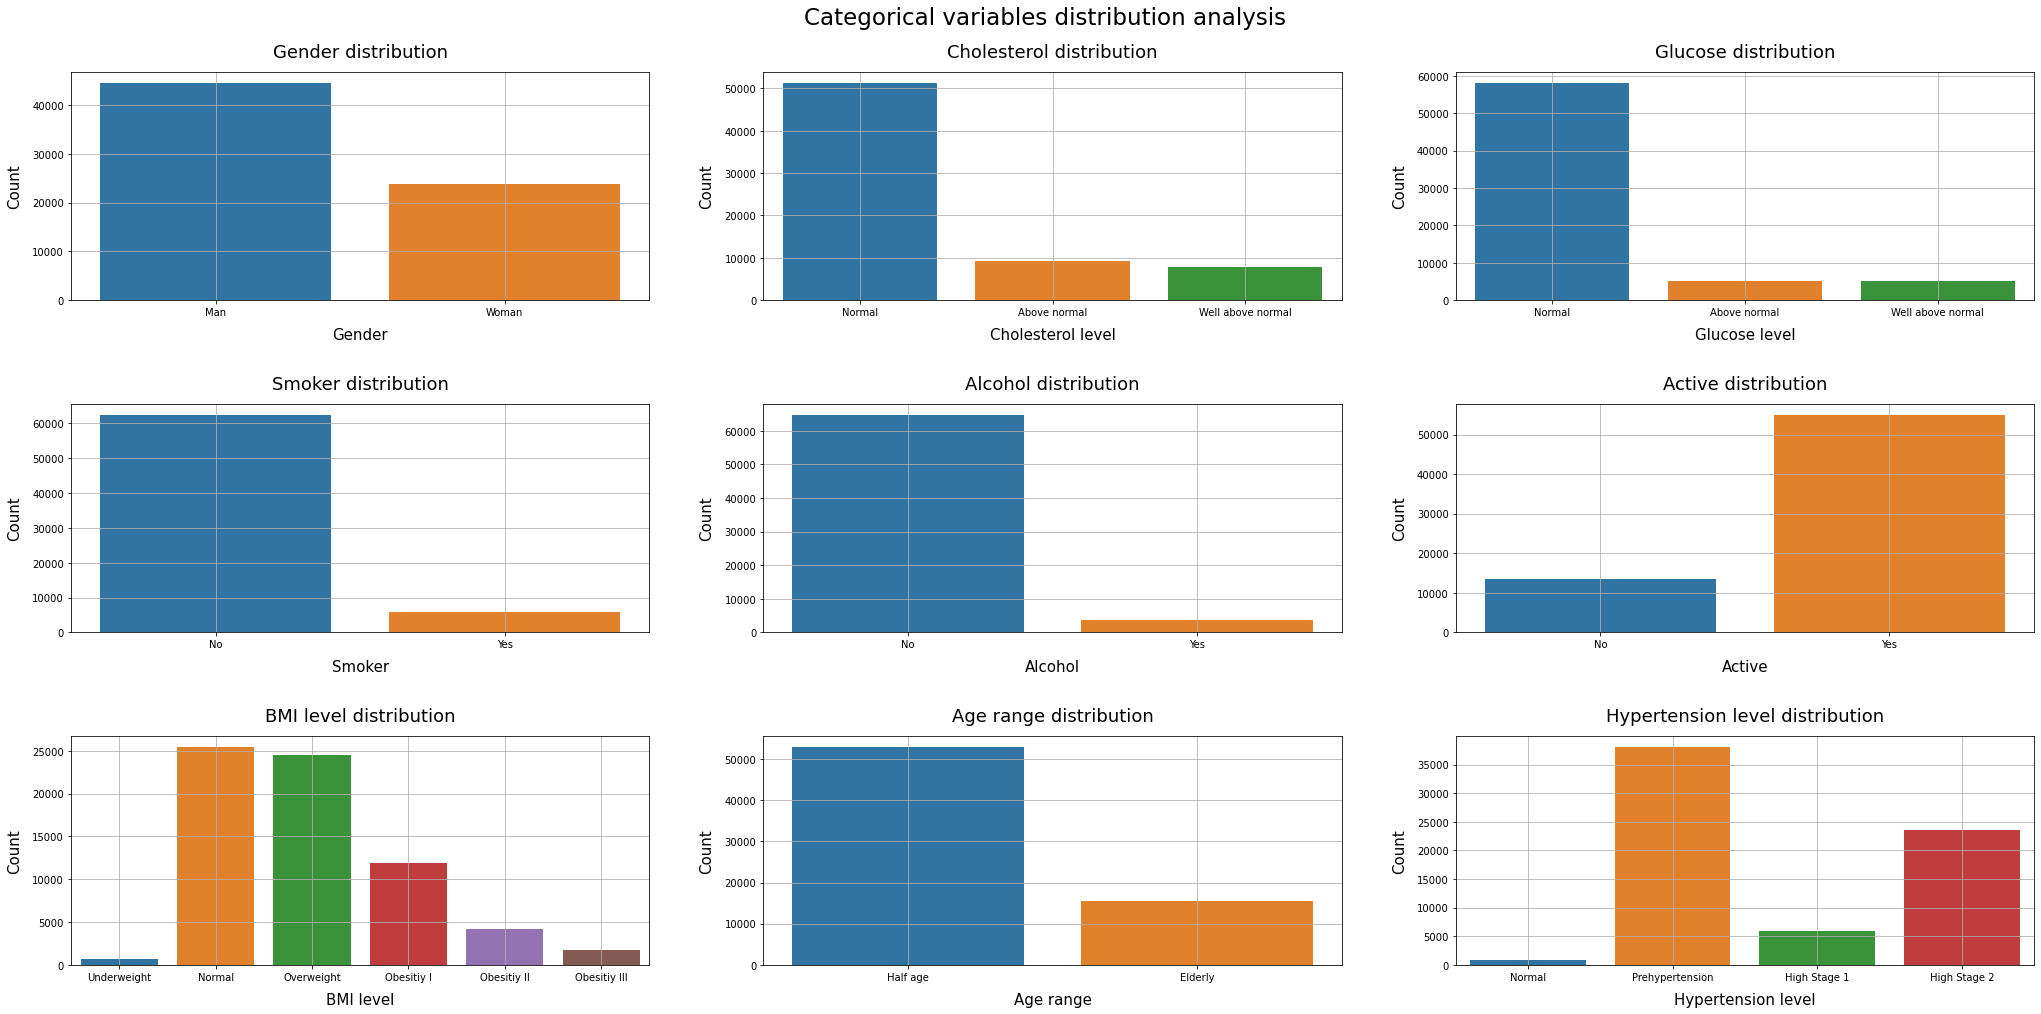

In [21]:
# creating a figure with 3 rows and 3 columns of axes
fig, axes = plt.subplots(3, 3, figsize= (30, 15))
fig.tight_layout(pad= 8.3)

# setting the figure title and size
fig.suptitle('Categorical variables distribution analysis', size=23)

# setting 0,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[0,0], x= df3['gender'])
axes[0,0].set_title('Gender distribution', size= 18, pad= 15)
axes[0,0].set_xlabel('Gender', size= 15, labelpad= 10)
axes[0,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[0,0].set_xticklabels(['Man', 'Woman'])
axes[0,0].grid()

# setting 0,1 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[0,1], x= df3['cholesterol'])
axes[0,1].set_title('Cholesterol distribution', size= 18, pad= 15)
axes[0,1].set_xlabel('Cholesterol level', size= 15, labelpad= 10)
axes[0,1].set_ylabel('Count', size= 15, labelpad= 10)
axes[0,1].set_xticklabels(['Normal', 'Above normal', 'Well above normal'])
axes[0,1].grid()

# setting 0,2 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[0,2], x= df3['glucose'])
axes[0,2].set_title('Glucose distribution', size= 18, pad= 15)
axes[0,2].set_xlabel('Glucose level', size= 15, labelpad= 10)
axes[0,2].set_ylabel('Count', size= 15, labelpad= 10)
axes[0,2].set_xticklabels(['Normal', 'Above normal', 'Well above normal'])
axes[0,2].grid()

# setting 1,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[1,0], x= df3['smoker'])
axes[1,0].set_title('Smoker distribution', size= 18, pad= 15)
axes[1,0].set_xlabel('Smoker', size= 15, labelpad= 10)
axes[1,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[1,0].set_xticklabels(['No', 'Yes'])
axes[1,0].grid()

# setting 1,1 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[1,1], x= df3['alcohol'])
axes[1,1].set_title('Alcohol distribution', size= 18, pad= 15)
axes[1,1].set_xlabel('Alcohol', size= 15, labelpad= 10)
axes[1,1].set_ylabel('Count', size= 15, labelpad= 10)
axes[1,1].set_xticklabels(['No', 'Yes'])
axes[1,1].grid()

# setting 1,2 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[1,2], x= df3['active'])
axes[1,2].set_title('Active distribution', size= 18, pad= 15)
axes[1,2].set_xlabel('Active', size= 15, labelpad= 10)
axes[1,2].set_ylabel('Count', size= 15, labelpad= 10)
axes[1,2].set_xticklabels(['No', 'Yes'])
axes[1,2].grid()

# setting 2,0 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[2,0], x= df3['BMI_level'])
axes[2,0].set_title('BMI level distribution', size= 18, pad= 15)
axes[2,0].set_xlabel('BMI level', size= 15, labelpad= 10)
axes[2,0].set_ylabel('Count', size= 15, labelpad= 10)
axes[2,0].set_xticklabels(['Underweight', 'Normal', 'Overweight', 'Obesitiy I', 'Obesitiy II', 'Obesitiy III'])
axes[2,0].grid()

# setting 2,1 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[2,1], x= df3['age_range'])
axes[2,1].set_title('Age range distribution', size= 18, pad= 15)
axes[2,1].set_xlabel('Age range', size= 15, labelpad= 10)
axes[2,1].set_ylabel('Count', size= 15, labelpad= 10)
axes[2,1].set_xticklabels(['Half age', 'Elderly'])
axes[2,1].grid()

# setting 2,2 axes graph, title, labels, ticks and sizes
sns.countplot(ax= axes[2,2], x= df3['hypertension_level'])
axes[2,2].set_title('Hypertension level distribution', size= 18, pad= 15)
axes[2,2].set_xlabel('Hypertension level', size= 15, labelpad= 10)
axes[2,2].set_ylabel('Count', size= 15, labelpad= 10)
axes[2,2].set_xticklabels(['Normal', 'Prehypertension', 'High Stage 1', 'High Stage 2'])
axes[2,2].grid()

***
**As seen above:**

- Most of the patients are woman
- Most of the patients have a normal cholesterol level
- Most of the patients have a normal glucose level
- Most of the patients are a non smoker person
- Most of the patients are a non drinker person
- Most of the patients practice a physical activity
- Most of the patients have a normal or a overweight BMI level
- There are no younger patients
-  Most of the patients are a half age person
- Most of the patients have a prehypertension hypertension level

### <font color=green size= 4>4.1.2 NUMERICAL VARIABLES </font>
***

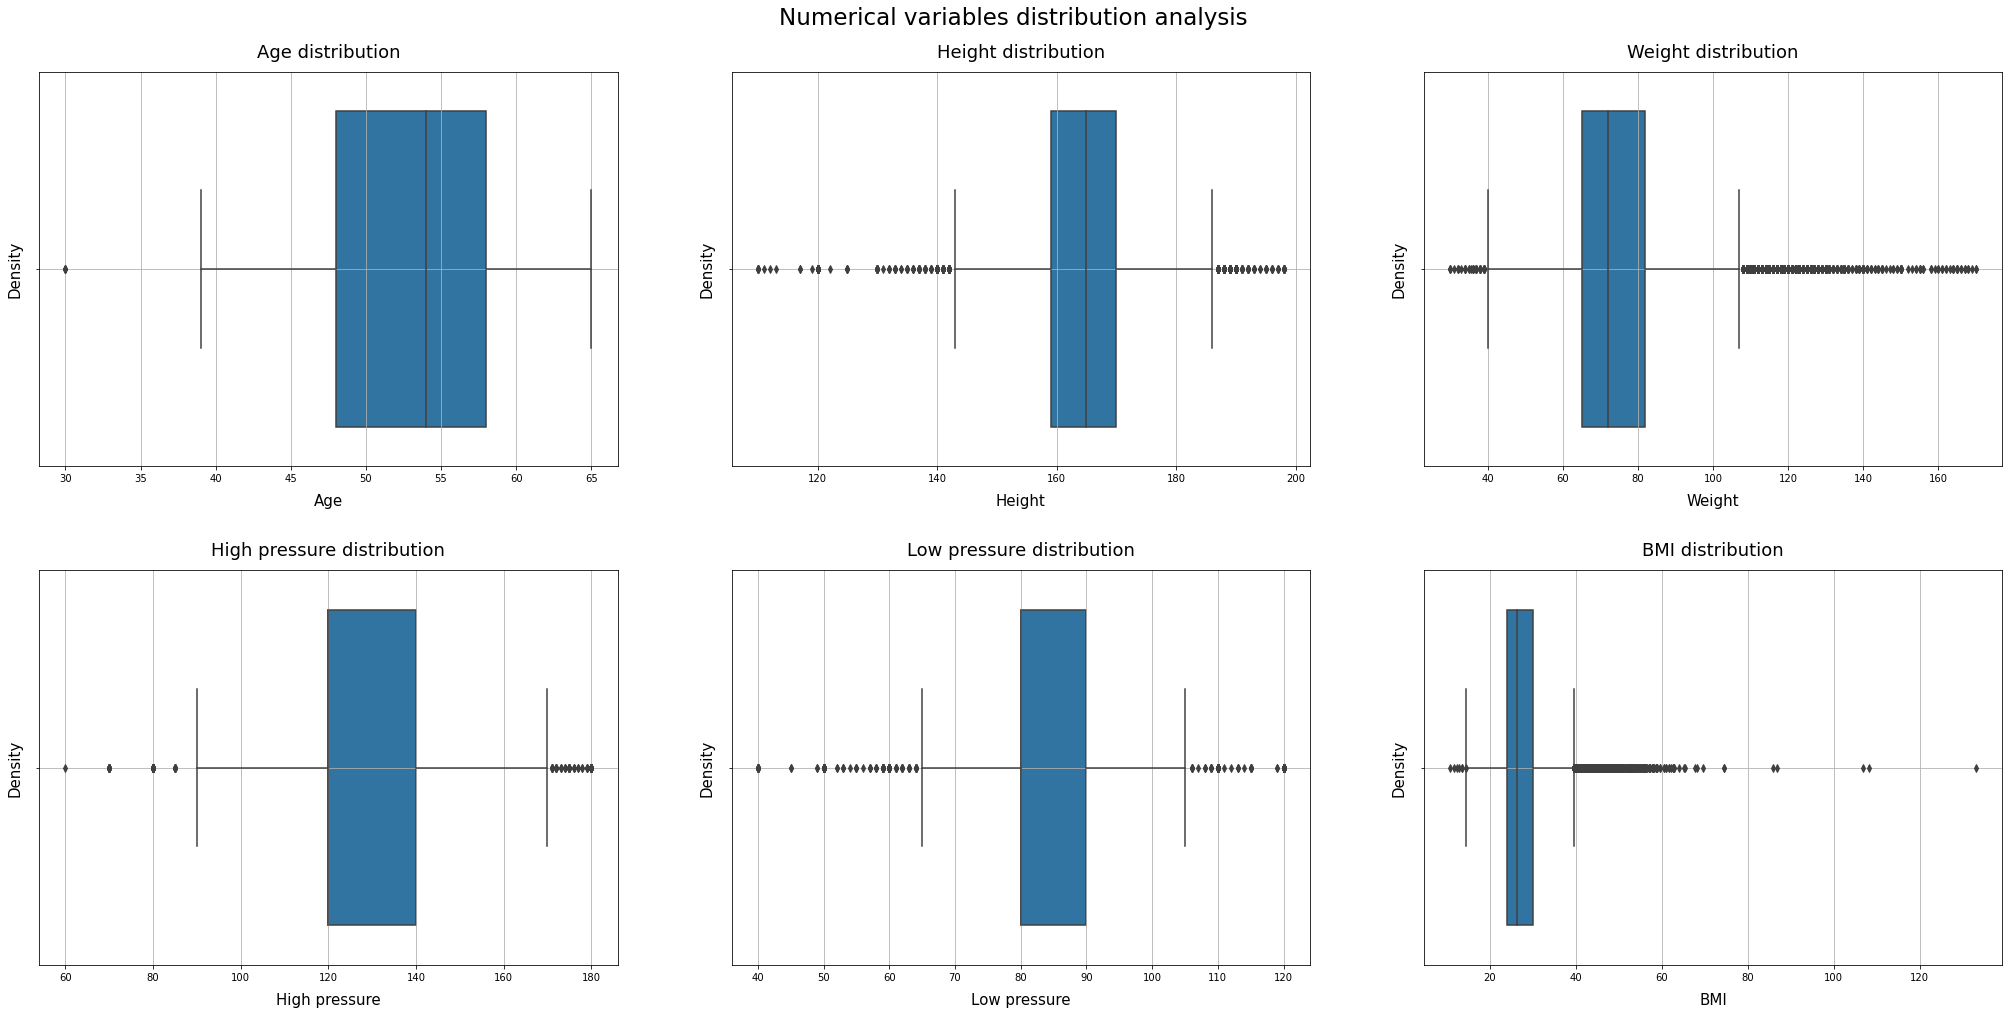

In [22]:
# creating a figure with 2 rows and 3 columns of axes
fig, axes = plt.subplots(2, 3, figsize= (30, 15))
fig.tight_layout(pad=8.3)

# setting the figure title and size
fig.suptitle('Numerical variables distribution analysis', size= 23)

# setting 0,0 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,0], x= df3['age'])
axes[0,0].set_title('Age distribution', size= 18, pad= 15)
axes[0,0].set_xlabel('Age', size= 15, labelpad= 10)
axes[0,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,0].grid()

# setting 0,1 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,1], x= df3['height'])
axes[0,1].set_title('Height distribution', size= 18, pad= 15)
axes[0,1].set_xlabel('Height', size= 15, labelpad= 10)
axes[0,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,1].grid()

# setting 0,2 axes graph, title, labels and sizes
sns.boxplot(ax= axes[0,2], x= df3['weight'])
axes[0,2].set_title('Weight distribution', size= 18, pad= 15)
axes[0,2].set_xlabel('Weight', size= 15, labelpad= 10)
axes[0,2].set_ylabel('Density', size= 15, labelpad= 10)
axes[0,2].grid()

# setting 1,0 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,0], x= df3['high_pressure'])
axes[1,0].set_title('High pressure distribution', size= 18, pad= 15)
axes[1,0].set_xlabel('High pressure', size= 15, labelpad= 10)
axes[1,0].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,0].grid()

# setting 1,1 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,1], x= df3['low_pressure'])
axes[1,1].set_title('Low pressure distribution', size= 18, pad= 15)
axes[1,1].set_xlabel('Low pressure', size= 15, labelpad= 10)
axes[1,1].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,1].grid()

# setting 1,2 axes graph, title, labels and sizes
sns.boxplot(ax= axes[1,2], x= df3['BMI'])
axes[1,2].set_title('BMI distribution', size= 18, pad= 15)
axes[1,2].set_xlabel('BMI', size= 15, labelpad= 10)
axes[1,2].set_ylabel('Density', size= 15, labelpad= 10)
axes[1,2].grid()

***
**As seen above:**

All numerical variables have a large number of outliers yet, except the 'age' feature.

## <font color=green size= 5>4.2 BIVARIATE ANALYSIS </font>
***


### <font color=green size= 4>4.2.1 **HYPOTESE 1 (H1):** Chances of having Heart diseases increases by being a man  </font> - **FALSE**
***

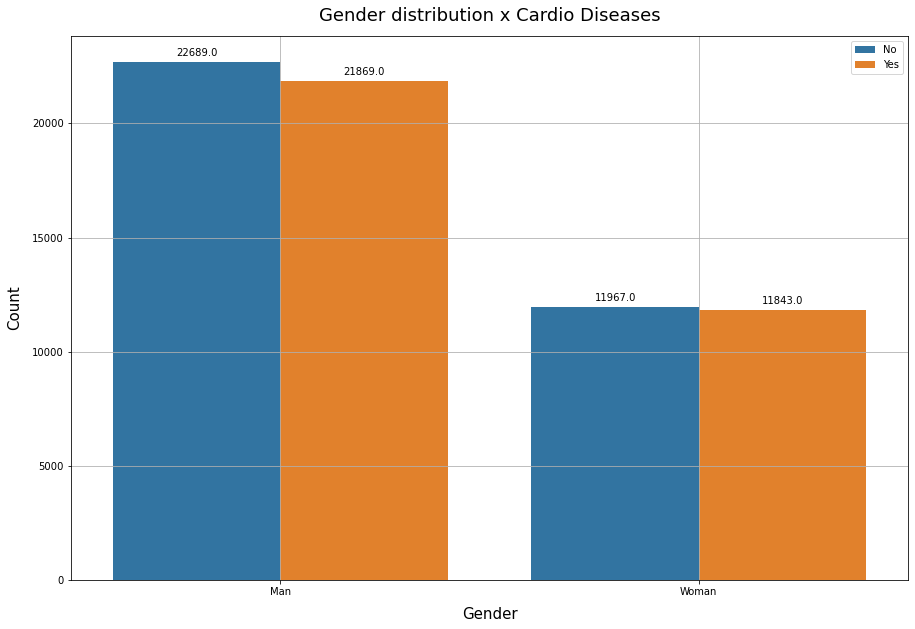

In [23]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['gender'], hue= cardio_disease_np)
ax.set_title('Gender distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Gender', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Man', 'Woman'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H1' in the images folder     
plt.savefig('../images/H1.png')

***
**As seen above:**

The proportion between sick and healthy men compared to the proportion between sick and healthy women are almost the same.

### <font color=green size= 4>4.2.2 **HYPOTESE 2 (H2):** Chances of having Heart diseases increases by increase the Body Mass Index </font> - **TRUE** 
***

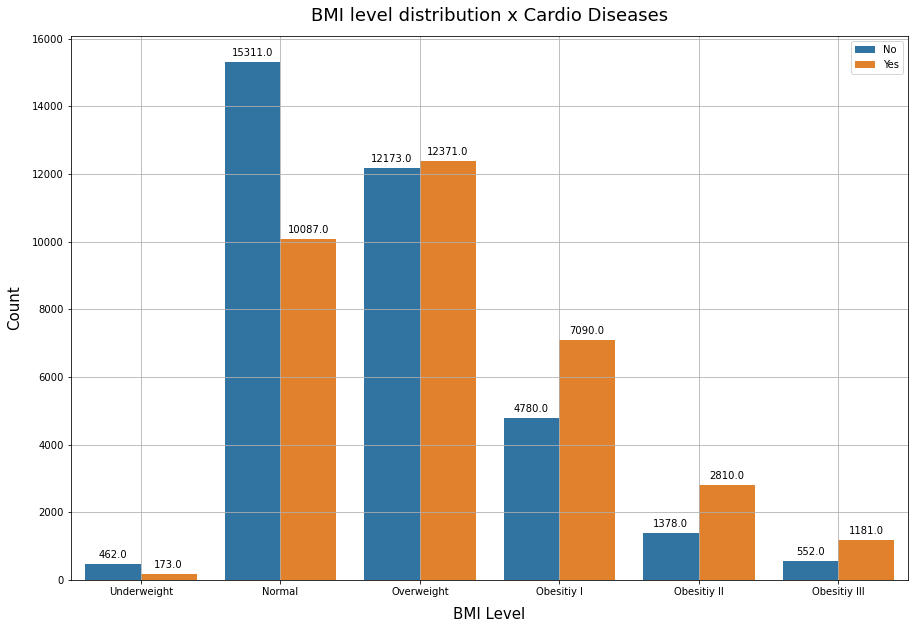

In [24]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['BMI_level'], hue= cardio_disease_np)
ax.set_title('BMI level distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('BMI Level', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Underweight', 'Normal', 'Overweight', 'Obesitiy I', 'Obesitiy II', 'Obesitiy III'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H2' in the images folder     
plt.savefig('../images/H2.png')

***
**As seen above:**

The proportion between sick and healthy people increase with the BMI Level growth.

### <font color=green size= 4>4.2.3 **HYPOTESE 3 (H3):** Chances of having Heart diseases increases by increase the Cholesterol level </font> - **TRUE** 
***

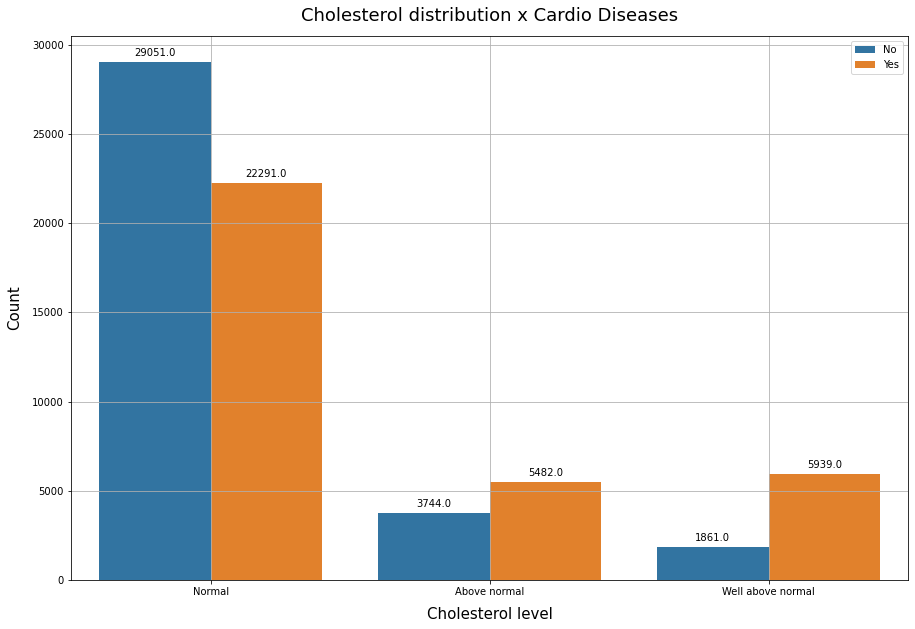

In [25]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['cholesterol'], hue= cardio_disease_np)
ax.set_title('Cholesterol distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Cholesterol level', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Normal', 'Above normal', 'Well above normal'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H3' in the images folder     
plt.savefig('../images/H3.png')

***
**As seen above:**

The proportion between sick and healthy people increase with the Cholesterol Level growth.

### <font color=green size= 4>4.2.4 **HYPOTESE 4 (H4):** Chances of having Heart diseases increases by increase the Glucose level </font> - **TRUE** 
***

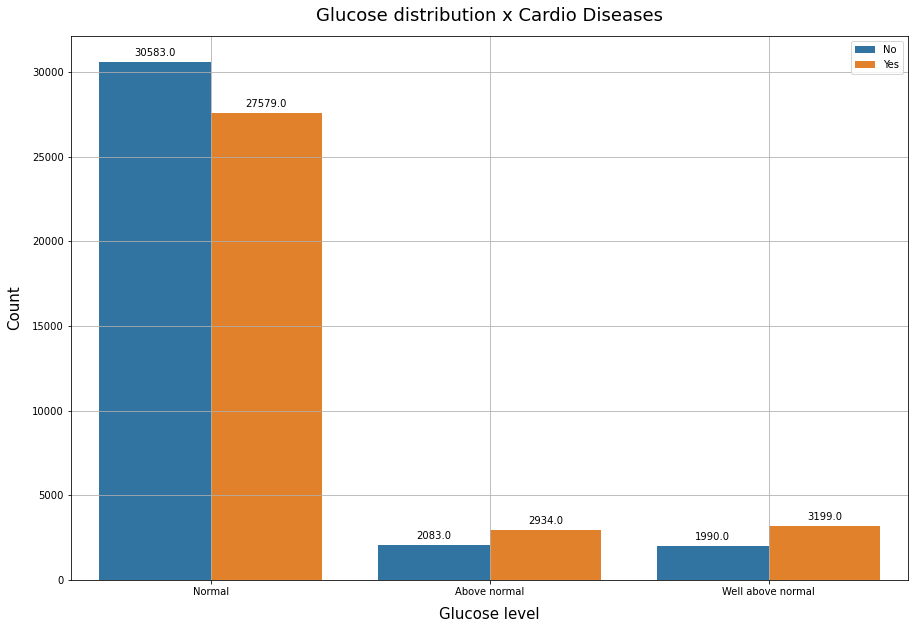

In [26]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['glucose'], hue= cardio_disease_np)
ax.set_title('Glucose distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Glucose level', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Normal', 'Above normal', 'Well above normal'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H4' in the images folder     
plt.savefig('../images/H4.png')

***
**As seen above:**

The proportion between sick and healthy people increase with the Glucose Level growth.

### <font color=green size= 4>4.2.5 **HYPOTESE 5 (H5):** Chances of having Heart diseases increases by being a smoker</font> - **FALSE** 
***

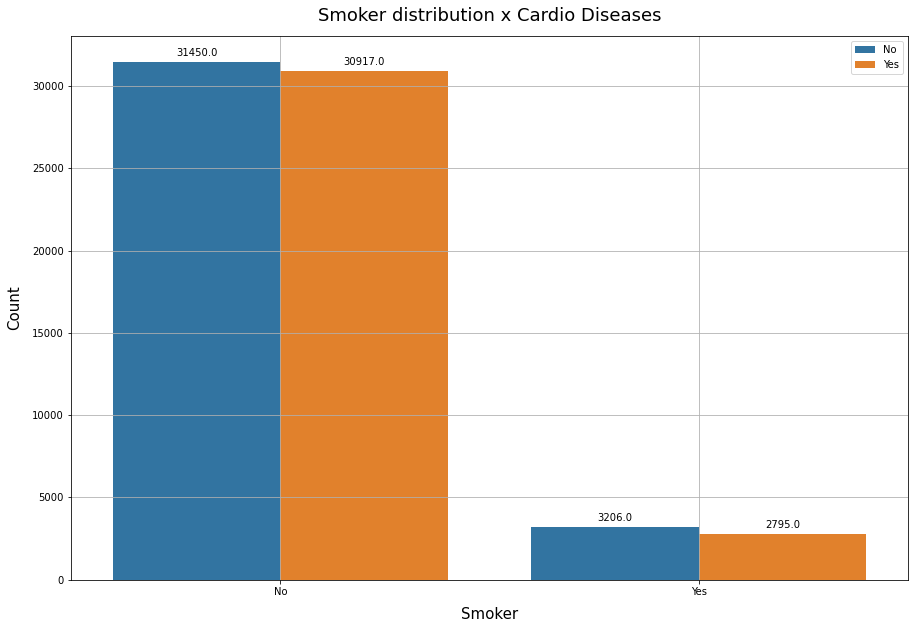

In [27]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['smoker'], hue= cardio_disease_np)
ax.set_title('Smoker distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Smoker', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['No', 'Yes'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H5' in the images folder     
plt.savefig('../images/H5.png')

***
**As seen above:**

The proportion between sick and healthy non smokers compared to the proportion between sick and healthy smokers are almost the same.

### <font color=green size= 4>4.2.6 **HYPOTESE 6 (H6):** Chances of having Heart diseases increases by intake alcohol through life </font> - **FALSE** 
***

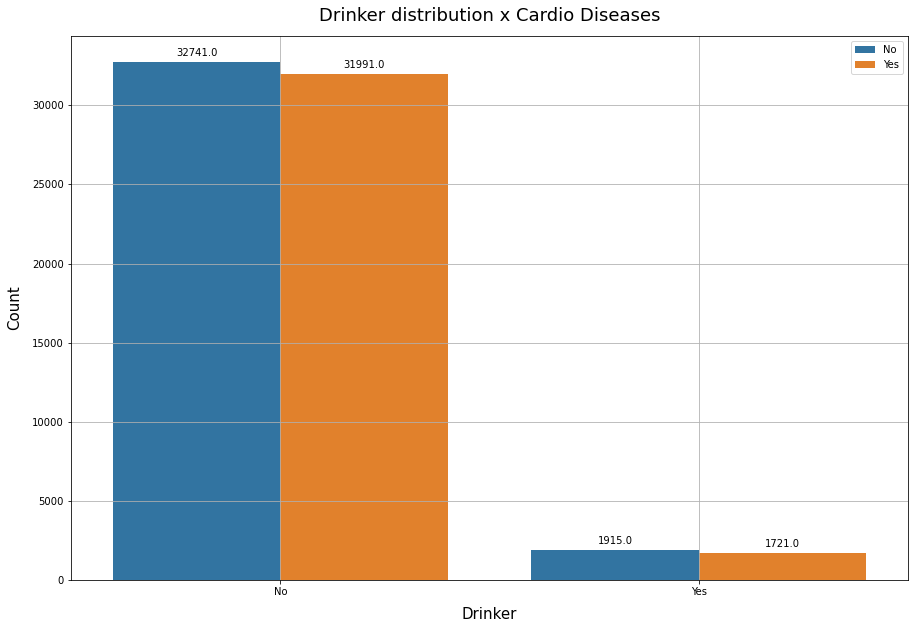

In [28]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['alcohol'], hue= cardio_disease_np)
ax.set_title('Drinker distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Drinker', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['No', 'Yes'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H6' in the images folder     
plt.savefig('../images/H6.png')

***
**As seen above:**

The proportion between sick and healthy non drinkers compared to the proportion between sick and healthy drinkers are almost the same.

### <font color=green size= 4>4.2.7 **HYPOTESE 7 (H7):** Chances of having Heart diseases increases by being an active person through life </font> - **TRUE** 
***

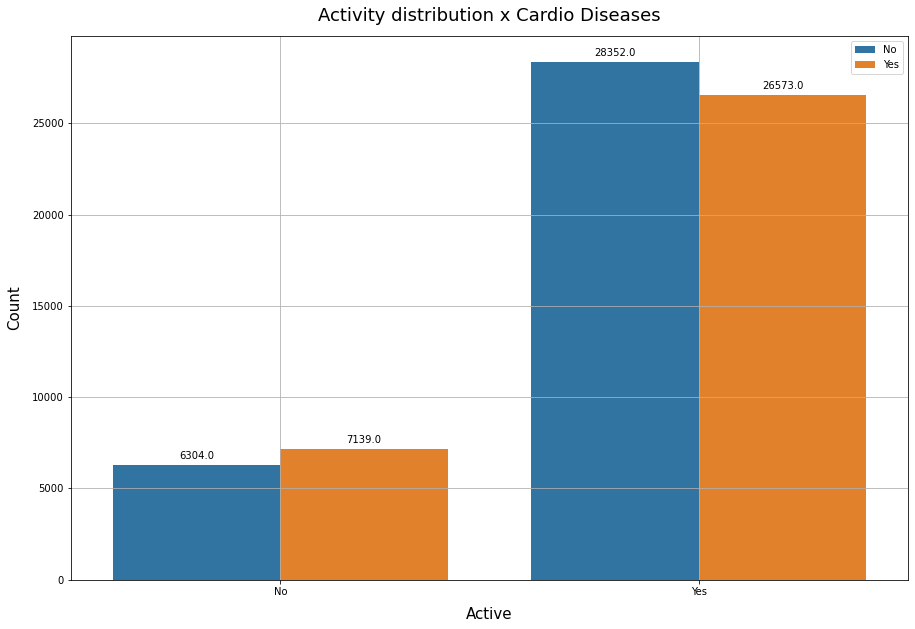

In [29]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize=(15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['active'], hue=cardio_disease_np)
ax.set_title('Activity distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Active', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['No', 'Yes'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H7' in the images folder     
plt.savefig('../images/H7.png')

***
**As seen above:**

The proportion between sick and healthy non sportists compared to the proportion between sick and healthy sportists is lower.

### <font color=green size= 4>4.2.8 **HYPOTESE 8 (H8):** Chances of having Heart diseases increases by being an older person</font> - **TRUE** 
***

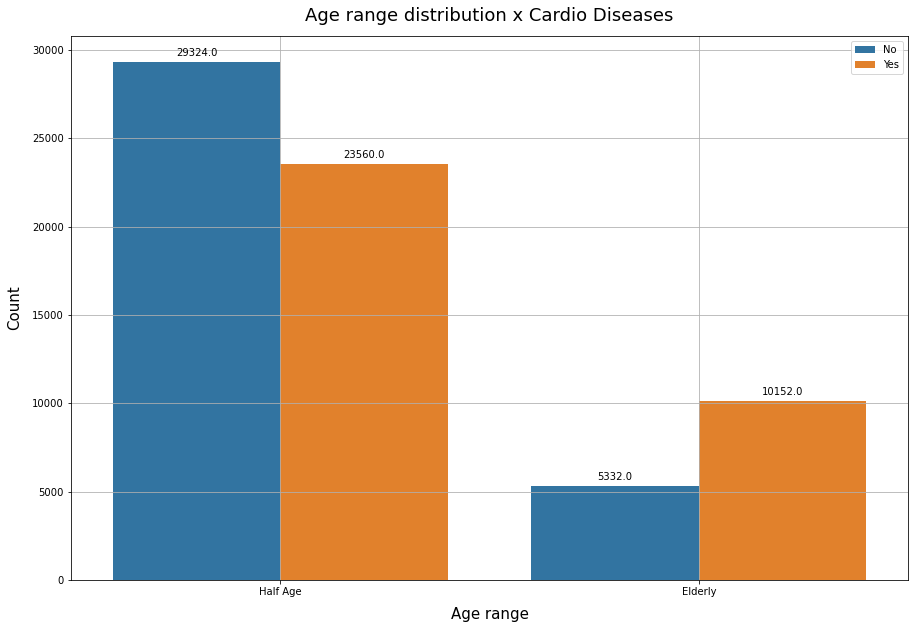

In [30]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['age_range'], hue= cardio_disease_np)
ax.set_title('Age range distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Age range', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Half Age', 'Elderly'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H8' in the images folder     
plt.savefig('../images/H8.png')

***
**As seen above:**

The proportion between sick and healthy people increase with the Age Range Level growth.

### <font color=green size= 4>4.2.9 **HYPOTESE 9 (H9):** Chances of having Heart diseases increases by being hypertensive person </font> - **TRUE** 
***

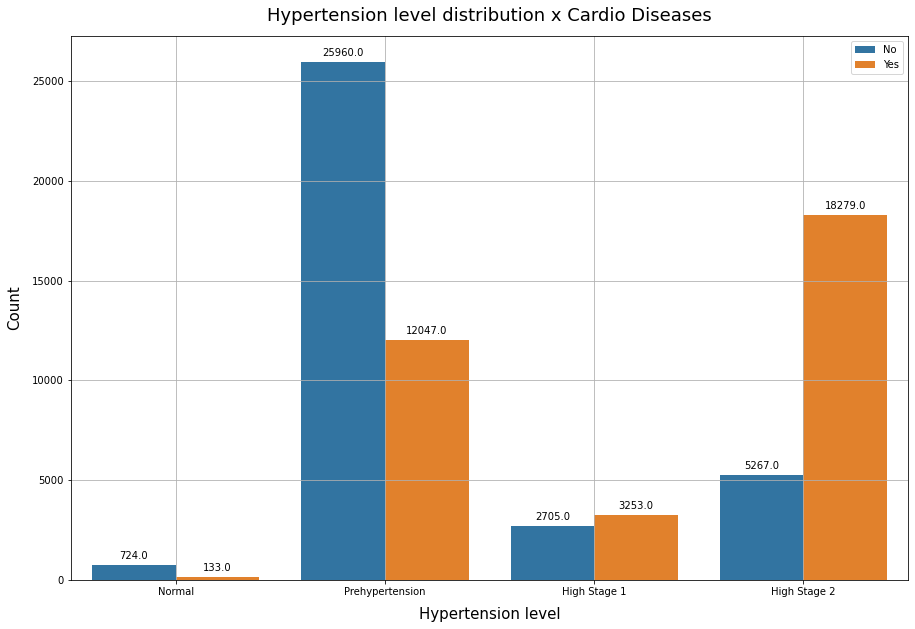

In [31]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize=(15,10))

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(df3['cardio_disease'].values== 0, 'No', 'Yes')

# setting the graph, title, labels, ticks and sizes
ax = sns.countplot(x= df3['hypertension_level'], hue= cardio_disease_np)
ax.set_title('Hypertension level distribution x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Hypertension level', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Normal', 'Prehypertension', 'High Stage 1', 'High Stage 2'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H9' in the images folder     
plt.savefig('../images/H9.png')

***
**As seen above:**

The proportion between sick and healthy people increase with the Hypertension Level growth.

### <font color=green size= 4>4.2.10 **HYPOTESE 10 (H10):** Chances of having Heart diseases are higher between hypertensive older people than general hypertensive people </font> - **TRUE** 
***

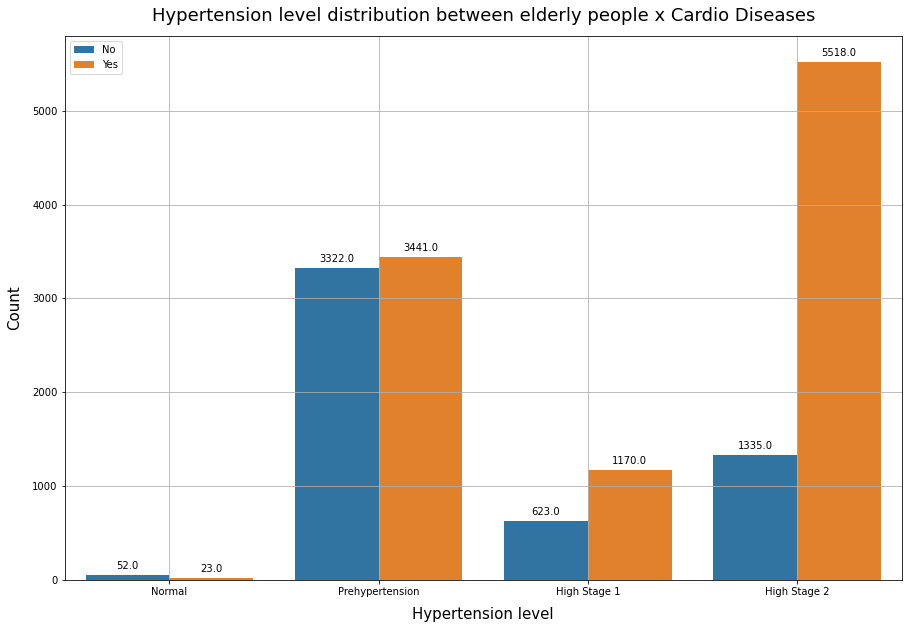

In [32]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (15,10))

# creating a auxiliar dataframe with only 'age_range' values equals to 3 (elderly people)
aux = df3[df3['age_range']== 3]

# resetting the auxiliar dataframe index
aux.reset_index(inplace= True, drop= True)

# creating a numpy array with no/yes values for 'cardio_disease' dataframe column
cardio_disease_np = np.where(aux['cardio_disease'].values== 0, 'No', 'Yes')

# set the graph, title, labels, ticks and sizes
ax = sns.countplot(x= aux['hypertension_level'], hue= cardio_disease_np)
ax.set_title('Hypertension level distribution between elderly people x Cardio Diseases', size= 18, pad= 15)
ax.set_xlabel('Hypertension level', size= 15, labelpad= 10)
ax.set_ylabel('Count', size= 15, labelpad= 10)
ax.set_xticklabels(['Normal', 'Prehypertension', 'High Stage 1', 'High Stage 2'])
ax.grid()

# setting values annotations for each graph's column
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
    
# saving the graph as 'H10' in the images folder     
plt.savefig('../images/H10.png')

***
**As seen above:**

- Between elderlies, the proportion between sick and healthy people increase with the Hypertension Level growth
- This increase exponentially higher than the increase between people in general
- Prehypertense elderlies are more likely to have cardiovascular diseases than prehypertense people in general

## <font color=green size= 5>4.3 MULTIVARIATE ANALYSIS </font>
***

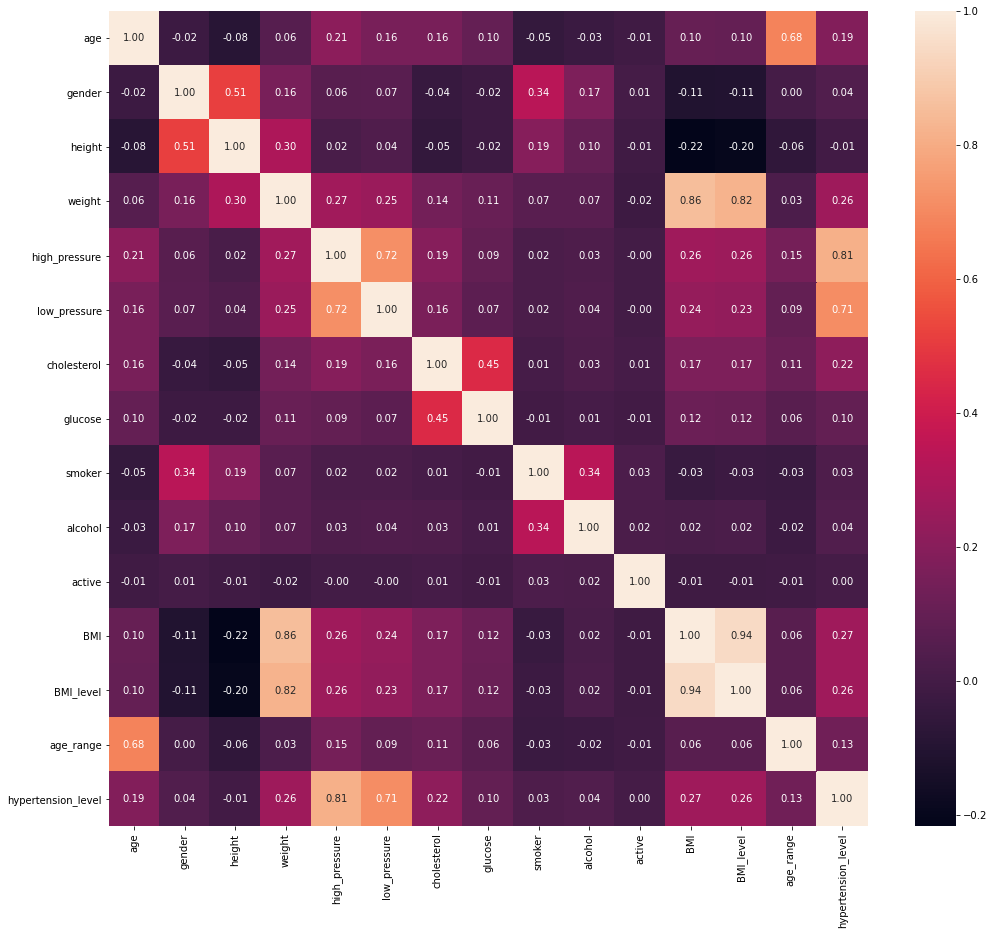

In [33]:
# creating a dataset with only the numerical values from 'df3' dataset
df3_num = df3.select_dtypes(include= ['float64', 'int64', 'int32'])

# drop the 'cardio_disease' column, which we are not interesed now
df3_num.drop(columns = ['cardio_disease'], axis= 1, inplace= True)

# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (17, 15))

# creating a correlation matrix from 'df3_num' dataframe
corre = df3_num.corr(method = 'pearson')

# creating a heatmap graph using the correlation matrix 'corre' as data
ax = sns.heatmap(corre, annot = True, fmt= '.2f')

# plotting the heat map
ax;

***
**As seen above:**

There are some variables that have a strong correlation between them.

This correlation isn't good for the model, because it increases the dimensionality without a considerable variance. So in this case, we should remove one of them, and that's what we gonna do.

**In this case, there are a few correlated variables, which are:**

- 'BMI'                and   'BMI_level'                  (94% correlation)
<br>
<br>

**In this situation we are gonna exclude the following variables:**

- 'BMI_level'

In [34]:
# deleting the unecessary variables from the 'df3' dataset
df3.drop(columns= ['BMI_level'], inplace= True)

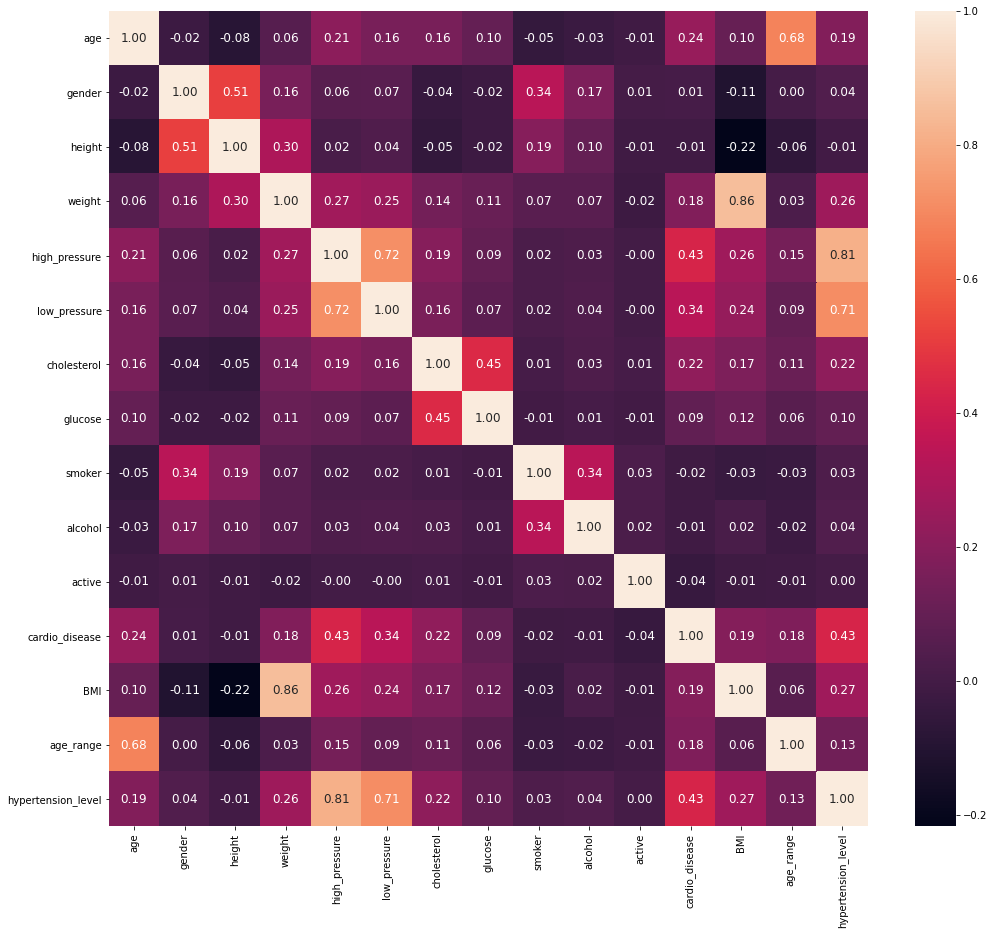

In [35]:
# creating a dataset with only the numerical values from 'df3' dataset
df3_num = df3.select_dtypes(include= ['float64', 'int64', 'int32'])

# creating a correlation matrix from 'df3_num' dataset
corre = df3_num.corr()

# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (17, 15))

# creating a heatmap graph using the correlation matrix 'corre' as data
ax= sns.heatmap(corre, annot= True, fmt= ".2f", annot_kws= {"size":12})

# plotting the heat map
ax;

***
**As seen above:** 
<br>

**There are some variables that have considerable impact over 'cardio_disease' result values:**

- 'high_pressure'
- 'hypertension_level'
- 'low_pressure'
- 'age'
- 'cholesterol'
- 'BMI'
- 'age_range'
- 'weight'

# <font color=green size= 6> <b>5. DATA PREPARATION </font></b>
***

In [36]:
# creating a dataframe's copy to work, from the original 'df3' dataframe
df4 = df3.copy()

# displaying the first 5 dataframe's registers 
df4.head()

,age,gender,height,weight,high_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio_disease,BMI,age_range,hypertension_level
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120,2,3
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679,2,5
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.507805,2,4
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479,2,5
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,2,3


## <font color=green size= 5>5.1 SAMPLING THE DATASET </font>
***

**We don't need to sample the dataset, because our processor capacity can handle it.**

## <font color=green size= 5>5.2 RESCALE AND NORMALIZE NUMERICAL FEATURES </font>
***

In the section we will executed the numerical variables rescaling and normalization. For this, these variables outliers must be known, to choose the best method to be applied.

**The techniques that will be used:**

- **RobustScaler:** Robust in the presence of outliers, will be applied at variables that have a significant amount of outliers 

- **MinMaxScaler:** Sensitive in the presence of outliers, will be applied at variables that have a significant amount of outliers 

As seen on section 4.1.2, all numerical variables have significant amount of outliers, even with some outliers removal (on section 3.3), except the 'step' variable.

In [37]:
# instantiating MinMaxScaler method as 'mms'
mms = MinMaxScaler()

# instantiating RobustScaler method as 'rs'
rs = RobustScaler()


# rescaling the dataset's 'age' feature 
df4['age'] = mms.fit_transform(df4[['age']].values)

# saving the 'age' feature rescaling method
pickle.dump(mms, open('../parameters/age_scaler.pkl', 'wb'))



# rescaling the dataset's 'height' feature        
df4['height'] = rs.fit_transform(df4[['height']].values)

# saving the 'height' feature rescaling method
pickle.dump(rs, open('../parameters/height_scaler.pkl', 'wb'))



# rescaling the dataset's 'weight' feature        
df4['weight'] = rs.fit_transform(df4[['weight']].values)

# saving the 'weight' feature rescaling method
pickle.dump(rs, open('../parameters/weight_scaler.pkl', 'wb'))



# rescaling the dataset's 'high_pressure' feature        
df4['high_pressure'] = rs.fit_transform(df4[['high_pressure']].values)

# saving the 'high_pressure' feature rescaling method
pickle.dump(rs, open('../parameters/high_pressure_scaler.pkl', 'wb'))



# rescaling the dataset's 'low_pressure' feature        
df4['low_pressure'] = rs.fit_transform(df4[['low_pressure']].values)

# saving the 'low_pressure' feature rescaling method
pickle.dump(rs, open('../parameters/low_pressure_scaler.pkl', 'wb'))



# rescaling the dataset's 'BMI' feature        
df4['BMI'] = rs.fit_transform(df4[['BMI']].values)

# saving the 'BMI' feature rescaling method
pickle.dump(rs, open('../parameters/bmi_scaler.pkl', 'wb'))

## <font color=green size= 5>5.3 ENCODE CATEGORICAL FEATURES </font>
***

- **All binary categorical features are already in 0 or 1 values**
- **All non binary categorical features are ordinal types, so they don't need to be encoded**

# <font color=green size= 6> <b>6. FEATURE SELECTION </font></b>
***

In [38]:
# creating a dataframe's copy to work, from the original 'df4' dataframe
df5 = df4.copy()

# displaying the first 5 dataframe's registers 
df5.head()

,age,gender,height,weight,high_pressure,low_pressure,cholesterol,glucose,smoker,alcohol,active,cardio_disease,BMI,age_range,hypertension_level
0,0.571429,2,0.272727,-0.588235,-0.5,0.0,1,1,0,0,1,0,-0.696448,2,3
1,0.714286,1,-0.818182,0.764706,1.0,1.0,3,1,0,0,1,1,1.380199,2,5
2,0.628571,1,0.000000,-0.470588,0.5,-1.0,3,1,0,0,0,1,-0.449587,2,4
3,0.514286,2,0.363636,0.588235,1.5,2.0,1,1,0,0,1,1,0.384028,2,5
4,0.514286,1,-0.818182,-0.941176,-1.0,-2.0,1,1,0,0,0,0,-0.529161,2,3


## <font color=green size= 5>6.1 BORUTA BEST FEATURES SELECTION </font>
***

**Boruta library:** <a href="https://pypi.org/project/Boruta/">Here</a></font>

In [39]:
# defining model that will be checked by the boruta method
rf_model = RandomForestClassifier(n_jobs = -1)

# defining the train arrays
x_train_boruta = df5.drop(columns= ['cardio_disease']).values
y_train_boruta = df5['cardio_disease'].values.ravel()

# instantiating the boruta method
boruta = BorutaPy(rf_model, n_estimators= 'auto', verbose= 2)

# training the boruta method
boruta.fit(x_train_boruta, y_train_boruta)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	14
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	2
Rejected: 	12
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	12
Iteration: 	12 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	12


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	2
Tentative: 	0
Rejected: 	12


BorutaPy(estimator=RandomForestClassifier(n_estimators=20, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x2B2FADE3740),
         n_estimators='auto',
         random_state=RandomState(MT19937) at 0x2B2FADE3740, verbose=2)

In [40]:
# instantiating the dataset selected columns by the boruta method
cols = boruta.support_.tolist()
boruta_selected_features = df5.drop(columns= ['cardio_disease']).iloc[:, cols].columns.to_list()

# displaying the selected features by boruta
print('Boruta selected features:')
boruta_selected_features

Boruta selected features:


['high_pressure', 'BMI']

## <font color=green size= 5>6.2 RANDOM FOREST BEST FEATURES SELECTION </font>
***

Random forest features importance:


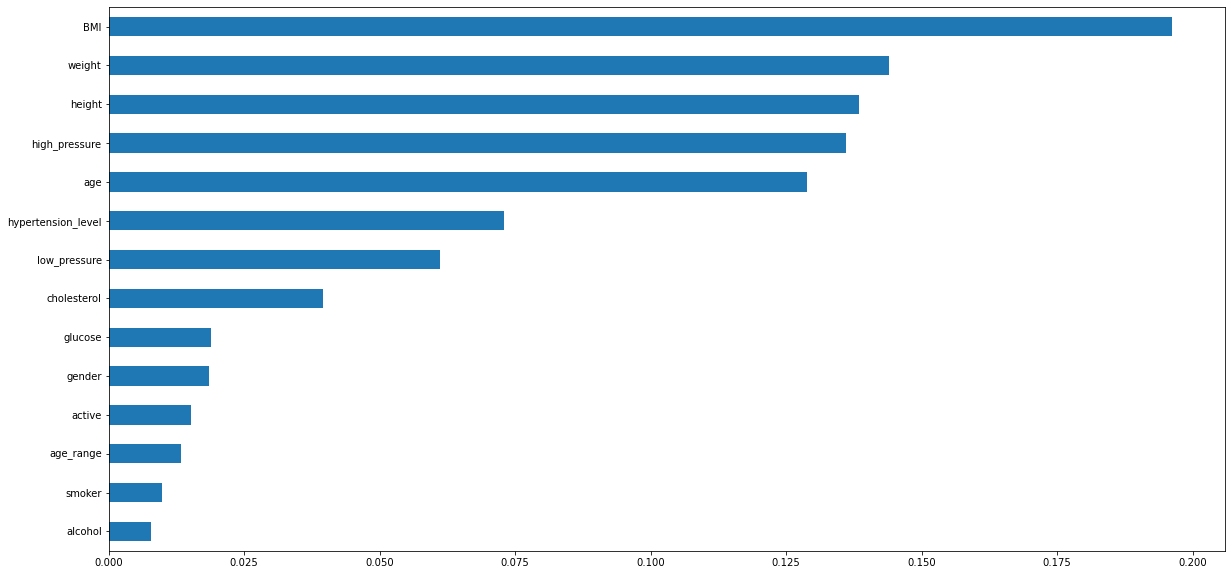

In [41]:
# define random forest model
rf_model = RandomForestClassifier(n_jobs= -1)

# define the train arrays
x_train_rfc = df5.drop(columns= ['cardio_disease'])
y_train_rfc = df5['cardio_disease']

# train the random forest model
rf_model.fit(x_train_rfc, y_train_rfc)

# create a figure with 1 rows and 1 columns of axes
plt.figure(figsize= (20, 10))

# create a series and plot the model's features importance
feat_importances = pd.Series(rf_model.feature_importances_, index= x_train_rfc.columns)
print('Random forest features importance:')
feat_importances.sort_values().plot(kind= 'barh');

## <font color=green size= 5>6.3 RECURSIVE FEATURE ELIMINATION (RFE) BEST FEATURES SELECTION </font>
***

In [42]:
# defining random forest model
rf = RandomForestClassifier(n_jobs= -1)

# defining the train arrays
x_train_rfe = df5.drop(columns= ['cardio_disease'])
y_train_rfe = df5['cardio_disease']

# defining the amount of features to select
rfe_selector = RFE(rf, n_features_to_select= 10, step= 1)

# training the model
rfe_selector = rfe_selector.fit(x_train_rfe, y_train_rfe)

# ranking the beast features
selected_features_T_F = rfe_selector.support_.tolist()

# getting the selected features columns names
features_columns = x_train_rfe.columns

# instantiating an empty list
rfe_selected_features = []

# inserting the selected columns into the empty list
for binary, feature in zip(selected_features_T_F, features_columns):
    if binary == True:
        rfe_selected_features.append(feature)

# displaying the selected features by RFE
print('RFE selected features:')
rfe_selected_features

RFE selected features:


['age',
 'gender',
 'height',
 'weight',
 'high_pressure',
 'low_pressure',
 'cholesterol',
 'glucose',
 'BMI',
 'hypertension_level']

## <font color=green size= 5>6.4 MANUAL BEST FEATURES SELECTION </font>
***

In [43]:
# creating a list with only the selected variables by analising the selected features by the methods above
manual_selected_features = ['age', 'weight', 'high_pressure', 'low_pressure', 'cholesterol', 'BMI']


# inserting the 'cardio_disease'/answer column at the manual selected features list
manual_selected_features.append('cardio_disease')

# filtering the dataset with only the manual selected columns and the answer column
df5 = df5[manual_selected_features]

# removing 'cardio_disease'/answer column from the manual selected features list
manual_selected_features.pop()

'cardio_disease'

## <font color=green size= 5>6.5 SPLIT TRAIN & TEST DATASET </font>
***

In [44]:
# creating the 'features' dataset by removing the 'cardio_disease'/aswer column
features = df5.drop(columns= ['cardio_disease'])

# creating the 'labels' dataset by filtering only the 'cardio_disease'/aswer column
labels = df5['cardio_disease']

# creating train and test features and labels datasets / series
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state= 301, test_size= 0.25, stratify= labels)

## <font color=green size= 5>6.4 RESAMPLING SELECTION </font>
***

In [45]:
# instantiating the 'SMOTETomek' method as 'resampler' variable
resampler = SMOTETomek(random_state= 301, n_jobs= -1)

# counting the 'labels' serie classes before balancing
print('Before balancing')
print(y_train.value_counts())

# balancing the train arrays
x_balanced, y_balanced = resampler.fit_resample(x_train, y_train)

# counting the 'labels' serie classes after balancing
print('After balancing')
print(y_balanced.value_counts())

Before balancing
0    25992
1    25284
Name: cardio_disease, dtype: int64
After balancing
1    22370
0    22370
Name: cardio_disease, dtype: int64


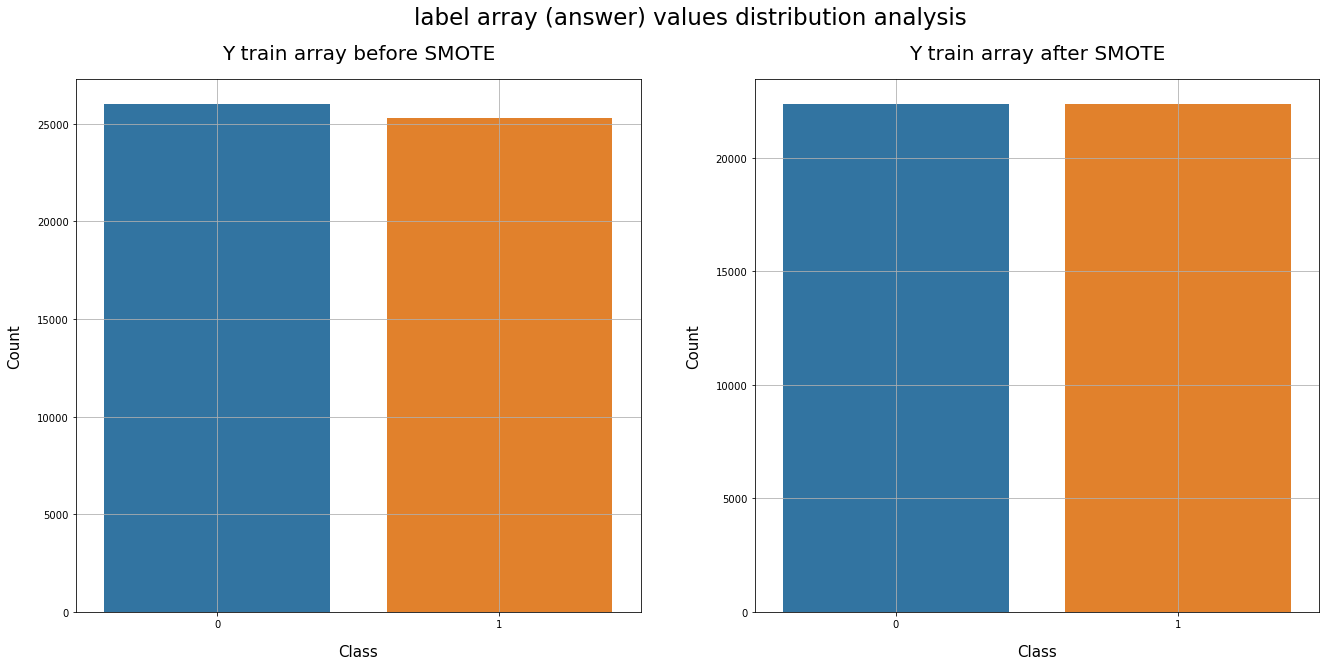

In [46]:
# create a figure with 1 row and 2 columns of axes
fig, axes = plt.subplots(1, 2, figsize= (20, 10))
fig.tight_layout(pad= 8.3)

# set the figure title and size
fig.suptitle("label array (answer) values distribution analysis", size= 23)

# set first axe's graph, title and labels
sns.countplot(ax= axes[0], x= y_train)
axes[0].set_title("Y train array before SMOTE", size= 20, pad= 20)
axes[0].set_xlabel("Class", size= 15, labelpad= 15)
axes[0].set_ylabel("Count", size= 15, labelpad= 15)
axes[0].grid()

# set second axe's graph, title and labels
sns.countplot(ax= axes[1], x= y_balanced)
axes[1].set_title("Y train array after SMOTE", size= 20, pad= 20)
axes[1].set_xlabel("Class", size= 15, labelpad= 15)
axes[1].set_ylabel("Count", size= 15, labelpad= 15)
axes[1].grid()

### <font color=green size= 5>6.7 CHECKPOINT </font>
***

In [47]:
# saving the manual selected columns
pickle.dump(manual_selected_features, open('../parameters/manual_selected_features.pkl', 'wb'))

# saving y and x balanced and train arrays
pickle.dump(x_train, open('../parameters/x_train.pkl', 'wb'))
pickle.dump(y_train, open('../parameters/y_train.pkl', 'wb'))
pickle.dump(x_balanced, open('../parameters/x_balanced.pkl', 'wb'))
pickle.dump(y_balanced, open('../parameters/y_balanced.pkl', 'wb'))

In [48]:
# opening the manual selected columns
manual_selected_features = pickle.load(open('../parameters/manual_selected_features.pkl', 'rb'))

# open y and x balanced arrays
x_train = pickle.load(open('../parameters/x_train.pkl', 'rb'))
y_train = pickle.load(open('../parameters/y_train.pkl', 'rb'))
x_balanced = pickle.load(open('../parameters/x_balanced.pkl', 'rb'))
y_balanced = pickle.load(open('../parameters/y_balanced.pkl', 'rb'))

# <font color=green size= 6> <b>7. MACHINE LEARNING </font></b>
***

In this section, we will finally apply the Machine Learning models in which the motivation to use these algorithms is to build an intelligent model to predict the probability of patients having cardiovascular diseases. For this, we will use following supervised task classification algorithms:

- Dummy Classifier
- CatBoost Classifier
- Gaussian Naive Bayes
- Random Forest Classifier
- Logistic Regression 
- Linear Discriminant Analysis
- KNeighbors Classifier
- XGB Classifier 
- SGD Classifier
- LGBM Classifier

## <font color=green size= 5>7.1 INSTANTIATE MODELS </font>
***

In [49]:
# instantiating dummy model as 'dummy'
dummy = DummyClassifier(random_state= 301)

# instantiating catboost model as 'cat'
cat = CatBoostClassifier(random_state= 301, verbose= False)

# instantiating Gaussian model as 'gnb'
gnb = GaussianNB()

# instantiating Random Forest model as 'rfc'
rfc = RandomForestClassifier(random_state= 301)

# instantiating Logistic Regression model as 'lr'
lr = LogisticRegression(random_state= 301)

# instantiating Linear Discrimination model as 'lda'
lda = LinearDiscriminantAnalysis()

# instantiating Kneighbors model as 'knc'
knc = KNeighborsClassifier(n_neighbors= 5, weights= 'distance', n_jobs= -1)

# instantiating XGBClassifier model as 'xgb'
xgb = XGBClassifier(random_state= 301, objective= 'binary:logistic')

# instantiating SGDC model as 'sgd'
sgd = SGDClassifier(random_state= 301, loss= 'log' , n_jobs= -1)

# instantiating LGBM model as 'lgbm'
lgbm = LGBMClassifier(random_state= 301, n_jobs= -1)

## <font color=green size= 5>7.2 MODELS TRAINING AND PERFORMANCE RESULTS </font>
***

### <font color=green size= 4>7.2.1 TRANING AND PRELIMINAR PERFORMANCE RESULTS </font>
***

In [50]:
# creating a list with the models instances
models =[lgbm, sgd, xgb, knc, lda, lr, rfc, gnb, cat, dummy]

# getting the models trained performance metrics for 'y_test' array (using the helper functions at section 1.2)
df_models_performance = get_models_performance(x_balanced, x_test, np.ravel(y_balanced), np.ravel(y_test), models)   

# displaying the 'df_models_performance' dataset and hightlight the maximum values for each column
df_models_performance.style.highlight_max(color= 'yellow')

Training LGBMClassifier...
Training SGDClassifier...
Training XGBClassifier...
[13:57:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training KNeighborsClassifier...
Training LinearDiscriminantAnalysis...
Training LogisticRegression...
Training RandomForestClassifier...
Training GaussianNB...
Training CatBoostClassifier...
Training DummyClassifier...


,model,precision,recall,f1_score,accuracy,kappa_score
0,LGBMClassifier,0.749640,0.679639,0.712926,0.730108,0.459425
2,SGDClassifier,0.750543,0.655790,0.699975,0.722794,0.444528
4,XGBClassifier,0.745195,0.676317,0.709088,0.726363,0.451932
6,KNeighborsClassifier,0.685848,0.680233,0.683029,0.688685,0.377181
8,LinearDiscriminantAnalysis,0.748343,0.656621,0.699488,0.721800,0.442563
10,LogisticRegression,0.743764,0.675724,0.708113,0.725310,0.449830
12,RandomForestClassifier,0.700722,0.690911,0.695782,0.702083,0.403938
14,GaussianNB,0.744251,0.629805,0.682262,0.710742,0.420159
16,CatBoostClassifier,0.748957,0.681419,0.713593,0.730283,0.459800
18,DummyClassifier,0.000000,0.000000,0.000000,0.506904,0.000000


***
**As seen above:**

- **On the business side:** We are aiming Precision score. Because each 5% increases on it is a R$ 500 increase in the diagnosis test price
<br>
<br>
- **On the patient side:** We are aiming Recall score. Because it reduces the chance of having a False Negative test result. As we know, false negatives results, frequently, comforts people into not retest. And in this case, there will be people with a growing disease that they don't know

So, we will choose the Top 4 best F1 Score models above to analyze, which is a metric that takes into account the Precision and the Recall metrics.

### <font color=green size= 4>7.2.2 CONFUSION MATRIX INDICATOR </font>
***

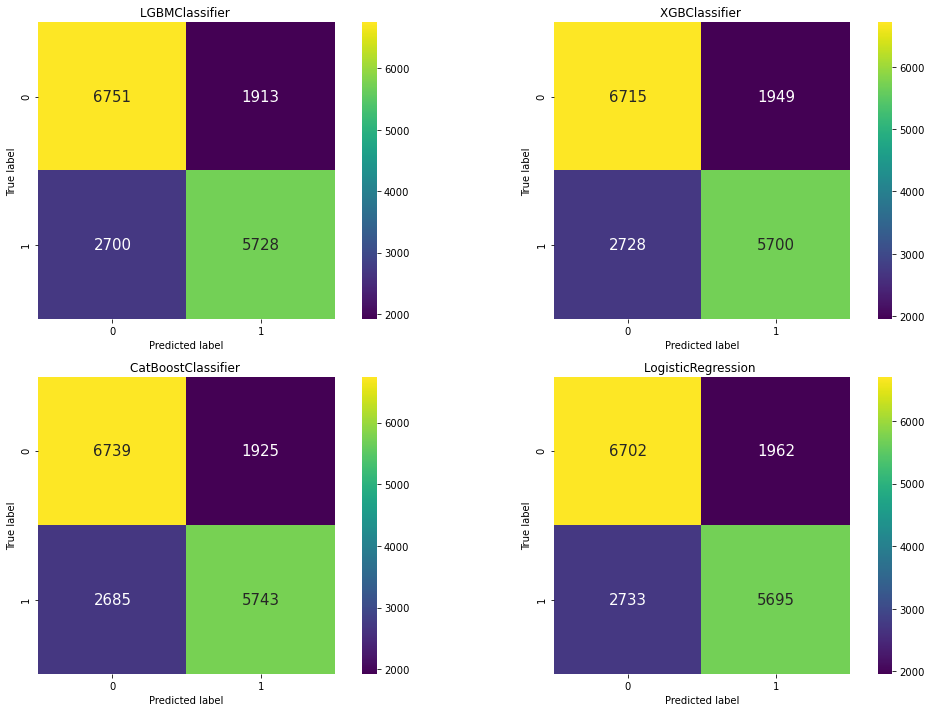

In [51]:
# creating a list with the top 4 recall score models
best_models = [lgbm, xgb, cat, lr]

#setting threshold value
thresh = 0.50

# plotting confusion matrices for each model prediction array VS. 'y_test' array (using the helper functions at section 1.2)
plot_multiple_confusion_matrices(2, 2, x_test, y_test, best_models, thresh)

***
**As seen above:**


- For the 'y_test' array predicting, the CatBoostClassier and the LGBMClassifer models have the higher Precision value between them all, with LGBMClassifer having the highest one, by a slightly difference. Which is important for the business interests.
<br>

- For the 'y_test' array predicting, the CatBoostClassier and the LGBMClassifer models have the lower False Negative values between them all, with CatBoostClassier having the lowest one, by a slightly difference of 15. Which is important for the patient interests.

### <font color=green size= 4>7.2.3 BRIER LOSS INDICATOR </font>
***

In [52]:
# predicting the probabilities to return class 1 for each one of the best models
y_pred_lgbm_prob = lgbm.predict_proba(x_test)[:,1]
y_pred_xgb_prob = xgb.predict_proba(x_test)[:,1]
y_pred_cat_prob = cat.predict_proba(x_test)[:,1]
y_pred_lr_prob = lr.predict_proba(x_test)[:,1]

# calculating the Brier Score Loss indicatior for each one of the best models 
lgbm_bsl = brier_score_loss(y_test, y_pred_lgbm_prob, pos_label= 1)
xgb_bsl = brier_score_loss(y_test, y_pred_xgb_prob, pos_label= 1)
cat_bsl = brier_score_loss(y_test, y_pred_cat_prob, pos_label= 1)
lr_bsl = brier_score_loss(y_test, y_pred_lr_prob, pos_label= 1)

# printing the Brier Score Loss indicatior calculated value for each one of the best models 
print("LGBM - Brier Score loss: {}".format(lgbm_bsl))
print("XGB - Brier Score loss: {}".format(xgb_bsl))
print("CAT - Brier Score loss: {}".format(cat_bsl))
print("LR - Brier Score loss: {}".format(lr_bsl))

LGBM - Brier Score loss: 0.18553399210350302
XGB - Brier Score loss: 0.18852887212938002
CAT - Brier Score loss: 0.18594265832166687
LR - Brier Score loss: 0.1887502858528313


***
- The Brier Score Loss measures the mean squared difference between the predicted probability and the actual outcome
- The Brier Score Loss fits analysis with categorical or binary outcomes. This is because the Brier Score Loss assumes that all possible outcomes are equivalently “distant” from one another. 
- The smaller the Brier score loss, the better. 

**As seen above:**

All models have the same Brier Score Loss value, approximately. With the LGBMClassifier model having the lowest one, by a slightly difference.

### <font color=green size= 4>7.2.4 ROC CURVE INDICATOR </font>
***

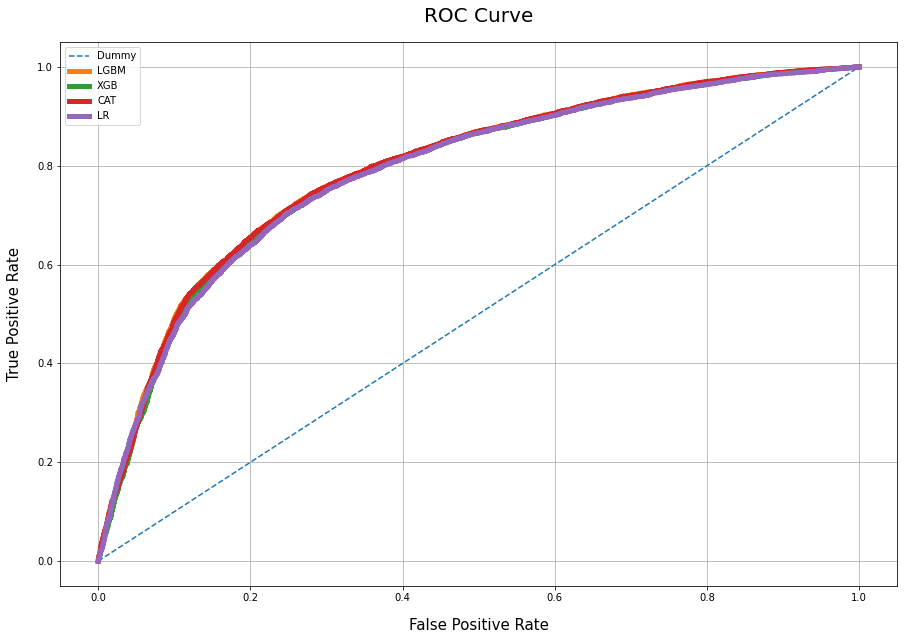

In [53]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize=(15,10))

# creating a list as a dummy classifier with the same size as 'y_test' array. Predicting all outcomes as class 0
dummy_probs = [0 for _ in range(len(y_test))]

# calculating the false posite rate and true positive rate by comparing 'y_test' and 'dummy_probs' array
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_probs)

# calculating the false posite rate and true positive rate for each one of the best models, by comparing 'y_test' and model probs array
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, y_pred_lgbm_prob)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, y_pred_xgb_prob)
cat_fpr, cat_tpr, _ = roc_curve(y_test, y_pred_cat_prob)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_pred_lr_prob)

# plotting the roc curve for each one of the best models
plt.plot(dummy_fpr, dummy_tpr, linestyle= '--', label= 'Dummy')
plt.plot(lgbm_fpr, lgbm_tpr, linestyle= '-', linewidth= 5 , label= 'LGBM')
plt.plot(xgb_fpr, xgb_tpr, linestyle= '-', linewidth= 5 , label= 'XGB')
plt.plot(cat_fpr, cat_tpr, linestyle= '-', linewidth= 5 , label= 'CAT')
plt.plot(lr_fpr, lr_tpr, linestyle= '-', linewidth= 5 , label= 'LR')

# setting figure title, labels and grid
plt.title("ROC Curve", fontsize= 20, pad = 20)
plt.xlabel('False Positive Rate', size= 15, labelpad= 15)
plt.ylabel('True Positive Rate', size= 15, labelpad= 15)
plt.grid()

# setting the figure legend
plt.legend()

# displaying the figure
plt.show()

***
**As seen above:**

CatBoostClassifier and LGBMClassifier have the best ROC curve growth behavior. These models behavior is almost the same.

### <font color=green size= 4>7.2.4 CLASSIFICATION REPORT INDICATOR </font>
***

In [54]:
# predicting the output for x_test arrays for each one of the best models
y_pred_lgbm = lgbm.predict(x_test)
y_pred_xgb = xgb.predict(x_test)
y_pred_cat = cat.predict(x_test)
y_pred_lr = lr.predict(x_test)

# printing the classification report between the real and predicted arrays for each model
print('\nClassification Report for ' + type(lgbm).__name__)
print(classification_report(y_test, y_pred_lgbm))

print('Classification Report for ' + type(xgb).__name__)
print(classification_report(y_test, y_pred_xgb))

print('\nClassification Report for ' + type(cat).__name__)
print(classification_report(y_test, y_pred_cat))

print('\nClassification Report for ' + type(lr).__name__)
print(classification_report(y_test, y_pred_lr))


Classification Report for LGBMClassifier
              precision    recall  f1-score   support

           0       0.71      0.78      0.75      8664
           1       0.75      0.68      0.71      8428

    accuracy                           0.73     17092
   macro avg       0.73      0.73      0.73     17092
weighted avg       0.73      0.73      0.73     17092

Classification Report for XGBClassifier
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8664
           1       0.75      0.68      0.71      8428

    accuracy                           0.73     17092
   macro avg       0.73      0.73      0.73     17092
weighted avg       0.73      0.73      0.73     17092


Classification Report for CatBoostClassifier
              precision    recall  f1-score   support

           0       0.72      0.78      0.75      8664
           1       0.75      0.68      0.71      8428

    accuracy                           0.73     17092


***
**As seen above:**

- LGBMClassifier and CatBoostClassifier models have the same classification report.
<br>

- Taking all the indicators values above, for both models, probably they will perform the same. 

But, with the LGBMClassifier having the best Brier Score Loss value and best Precision (important for the busines) and this not having a significant Recall reducing compared to the CatBoostClassifier, we will choose it to work.

## <font color=green size= 5>7.3 CROSS VALIDATION </font>
***

### <font color=green size= 4>7.3.1 LIGHT GRADIENT BOOST MACHINE CLASSIFIER METRICS</font>
***

In [55]:
# combining the train and test features and labels. This is because that cross validation split the train and test dataset by itself
x_cv = pd.concat([x_train, x_test], axis= 0)
y_cv = pd.concat([y_train, y_test], axis= 0)

# resetting the combined arrays index
x_cv.reset_index(drop= True, inplace= True)
y_cv.reset_index(drop= True, inplace= True)

In [56]:
print('Cross Validation for LGBM model:')

# creating the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 10 stratified arrays.
cv = StratifiedKFold(n_splits= 10, shuffle= True, random_state= 301)

# creating a cross validation analysis for 'lgbm' model, with precision model interval evaluation
cv_scores_precision = cross_val_score(lgbm, x_cv, np.ravel(y_cv), cv= cv, scoring= 'precision', n_jobs= -1) * 100
print("\n Precision interval: [{:.4f}%, {:.4f}%]".format(cv_scores_precision.mean() - cv_scores_precision.std()*2, cv_scores_precision.mean() + cv_scores_precision.std()*2)) 

# creating a cross validation analysis for 'lgbm' model, with recall model interval evaluation
cv_scores_recall = cross_val_score(lgbm, x_cv, np.ravel (y_cv), cv= cv, scoring = 'recall', n_jobs= -1) * 100
print("\n Recall interval: [{:.4f}%, {:.4f}%]".format(cv_scores_recall.mean() - cv_scores_recall.std()*2, cv_scores_recall.mean() + cv_scores_recall.std()*2)) 

# creating a cross validation analysis for 'lgbm' model, with f1 score model interval evaluation
cv_scores_f1_score = cross_val_score(lgbm, x_cv, np.ravel(y_cv), cv= cv, scoring= 'f1', n_jobs= -1) * 100
print("\n F1 Score interval: [{:.4f}%, {:.4f}%]".format(cv_scores_f1_score.mean() - cv_scores_f1_score.std()*2, cv_scores_f1_score.mean() + cv_scores_f1_score.std()*2)) 

# creating a cross validation analysis for 'lgbm' model, with accuracy model interval evaluation
cv_scores_accuracy = cross_val_score(lgbm, x_cv, np.ravel(y_cv), cv= cv, scoring= 'accuracy', n_jobs= -1) * 100
print("\n Accuracy interval: [{:.4f}%, {:.4f}%]".format(cv_scores_accuracy.mean() - cv_scores_accuracy.std()*2, cv_scores_accuracy.mean() + cv_scores_accuracy.std()*2)) 

Cross Validation for LGBM model:

 Precision interval: [74.0936%, 75.7140%]

 Recall interval: [67.5903%, 69.5299%]

 F1 Score interval: [70.9891%, 72.1911%]

 Accuracy interval: [72.6248%, 73.7127%]


## <font color=green size= 5>7.4 CHECKPOINT </font>
***

In [57]:
# training the 'lgbm' model, because it wasn't before
lgbm.fit(x_balanced, np.ravel(y_balanced))

LGBMClassifier(random_state=301)

In [58]:
# saving the trained LGBM model as a pickle file
pickle.dump(lgbm, open('../models/lgbm_model.pkl', 'wb'))
    
# saving the cross validation metrics 
pickle.dump(cv_scores_precision, open('../parameters/cv_scores_precision.pkl', 'wb'))
pickle.dump(cv_scores_recall, open('../parameters/cv_scores_recall.pkl', 'wb'))
pickle.dump(cv_scores_f1_score, open('../parameters/cv_scores_f1_score.pkl', 'wb'))
pickle.dump(cv_scores_accuracy, open('../parameters/cv_scores_accuracy.pkl', 'wb'))

In [59]:
# opening the trained XGB model as a pickle file
lgbm = pickle.load(open('../models/lgbm_model.pkl', 'rb'))

# opening the cross validation metrics 
cv_scores_precision = pickle.load(open('../parameters/cv_scores_precision.pkl', 'rb'))
cv_scores_recall = pickle.load(open('../parameters/cv_scores_recall.pkl', 'rb'))
cv_scores_f1_score = pickle.load(open('../parameters/cv_scores_f1_score.pkl', 'rb'))
cv_scores_accuracy = pickle.load(open('../parameters/cv_scores_accuracy.pkl', 'rb'))

# <font color=green size= 6> <b>8. HYPERPARAMETERS FINE TUNING </font></b>
***

## <font color=green size= 5>8.1 RANDOM SEARCH </font>
***

In [60]:
# creating a new LGBM model, not tuned
lgbm_not_tuned = LGBMClassifier(random_state= 301, n_jobs= -1)

In [61]:
# creating a dictionary with the hyperparameters to go through
params = {'max_depth': np.arange(2, 12, 2), 
         'num_leaves': 2 ** np.arange(2, 10, 2),
         'min_data_in_leaf': np.arange(100, 1050, 50), 
         'learning_rate': np.linspace(0.01, 0.6, 15),
         'colsample_bytree': np.linspace(0.1, 1, 5),
         'subsample': np.linspace(0.25, 1, 15),
         'n_estimators': np.arange(10, 105, 15)}

In [62]:
# creating the RandomizedSearchCV method over LGBM model, going through all hyperparameters in 'params'
lgbm_not_tuned_cv = RandomizedSearchCV(estimator= lgbm_not_tuned, 
                                param_distributions= params,
                                n_iter= 100,
                                scoring= 'f1',                                
                                cv= 10,
                                random_state= 301,
                                n_jobs= -1)

In [63]:
# training the RandomizedSearchCV method over LGBM model with 'x_balanced' and 'y_balanced' sets
lgbm_not_tuned_cv.fit(x_balanced, np.ravel(y_balanced))

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(random_state=301),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.1  , 0.325, 0.55 , 0.775, 1.   ]),
                                        'learning_rate': array([0.01      , 0.05214286, 0.09428571, 0.13642857, 0.17857143,
       0.22071429, 0.26285714, 0.305     , 0.34714286, 0.38928571,
       0.43142857, 0.47357143, 0.51571429, 0.55785714, 0.6       ]),
                                        'max_depth': arra...
                                        'min_data_in_leaf': array([ 100,  150,  200,  250,  300,  350,  400,  450,  500,  550,  600,
        650,  700,  750,  800,  850,  900,  950, 1000]),
                                        'n_estimators': array([ 10,  25,  40,  55,  70,  85, 100]),
                                        'num_leaves': array([  4,  16,  64, 256], dtype=int32),
                                        'subsample': array([0.25      , 0.303

In [64]:
# instantiating the best LGBM model as 'lgbm_tuned'
lgbm_tuned = lgbm_not_tuned_cv.best_estimator_

# getting the trained 'lgbm_tuned' model performance's metrics for 'y_test' array (using the helper functions at section 1.2)
df_tuned = get_models_performance(x_balanced, x_test, np.ravel(y_balanced), np.ravel(y_test), [lgbm_tuned])

# printing the 'xgb_not_tuned' model best hyparameters found at RandomizedSearchCV method
print("\n XGBoost Model tuned hyper parameters: \n {}".format(lgbm_not_tuned_cv.best_params_)) 

# printing the 'xgb_not_tuned' model best accuracy found at RandomizedSearchCV method
print("\n XGBoost Model tuned best accuracy score: {:.4f}%".format(lgbm_not_tuned_cv.best_score_ * 100))

# displaying the 'df_tuned' dataset
df_tuned

Training LGBMClassifier...

 XGBoost Model tuned hyper parameters: 
 {'subsample': 0.8928571428571428, 'num_leaves': 4, 'n_estimators': 40, 'min_data_in_leaf': 200, 'max_depth': 10, 'learning_rate': 0.5578571428571428, 'colsample_bytree': 1.0}

 XGBoost Model tuned best accuracy score: 75.8895%


,model,precision,recall,f1_score,accuracy,kappa_score
0,LGBMClassifier,0.740404,0.695776,0.717397,0.729698,0.458849


***
**PREENCHER**

## <font color=green size= 5>8.2 CALIBRATE THE CURVE </font>
***

In [65]:
# creating the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 10 stratified arrays.
cv = StratifiedKFold(n_splits= 10)

# training the the 'lgbm_tuned' model
lgbm_tuned.fit(x_balanced, np.ravel(y_balanced))

# defining and fit the calibration model
lgbm_tuned_calibrated = CalibratedClassifierCV(base_estimator= lgbm_tuned, method= 'isotonic', cv= cv)

# training the 'lgbm_tuned_calibrated' model
lgbm_tuned_calibrated.fit(x_train, np.ravel(y_train))

[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGBM] [Warning] min_data_in_leaf is set=200, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=200
[LightGB

CalibratedClassifierCV(base_estimator=LGBMClassifier(learning_rate=0.5578571428571428,
                                                     max_depth=10,
                                                     min_data_in_leaf=200,
                                                     n_estimators=40,
                                                     num_leaves=4,
                                                     random_state=301,
                                                     subsample=0.8928571428571428),
                       cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
                       method='isotonic')

## <font color=green size= 5>8.3 CROSS VALIDATION </font>
***

### <font color=green size= 4>8.3.1 LGBM TUNED MODEL METRICS</font>
***

In [66]:
# combining the train and test features and labels. This because that crossvalidation split the train and test dataset by itself
x_cv = pd.concat([x_train, x_test], axis= 0)
y_cv = pd.concat([y_train, y_test], axis= 0)

# resetting the combined arrays index
x_cv.reset_index(drop= True, inplace= True)
y_cv.reset_index(drop= True, inplace= True)

In [67]:
print('Cross Validation for LGBM tuned model:')

# creating the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 10 stratified arrays.
cv = StratifiedKFold(n_splits= 10, shuffle= True, random_state= 301)

# creating a cross validation analysis for 'lgbm_tuned' model, with precision model interval evaluation
cv_scores_precision_tuned = cross_val_score(lgbm_tuned, x_cv, np.ravel(y_cv), cv= cv, scoring= 'precision', n_jobs= -1) * 100
print("\n Precision interval: [{:.4f}%, {:.4f}%]".format(cv_scores_precision_tuned.mean() - cv_scores_precision_tuned.std()*2, cv_scores_precision_tuned.mean() + cv_scores_precision_tuned.std()*2)) 

# creating a cross validation analysis for 'lgbm_tuned' model, with recall model interval evaluation
cv_scores_recall_tuned = cross_val_score(lgbm_tuned, x_cv, np.ravel (y_cv), cv= cv, scoring = 'recall', n_jobs= -1) * 100
print("\n Recall interval: [{:.4f}%, {:.4f}%]".format(cv_scores_recall_tuned.mean() - cv_scores_recall_tuned.std()*2, cv_scores_recall_tuned.mean() + cv_scores_recall_tuned.std()*2)) 

# creating a cross validation analysis for 'lgbm_tuned' model, with f1 score model interval evaluation
cv_scores_f1_score_tuned = cross_val_score(lgbm_tuned, x_cv, np.ravel(y_cv), cv= cv, scoring= 'f1', n_jobs= -1) * 100
print("\n F1 Score interval: [{:.4f}%, {:.4f}%]".format(cv_scores_f1_score_tuned.mean() - cv_scores_f1_score_tuned.std()*2, cv_scores_f1_score_tuned.mean() + cv_scores_f1_score_tuned.std()*2)) 

# creating a cross validation analysis for 'lgbm_tuned' model, with accuracy model interval evaluation
cv_scores_accuracy_tuned = cross_val_score(lgbm_tuned, x_cv, np.ravel(y_cv), cv= cv, scoring= 'accuracy', n_jobs= -1) * 100
print("\n Accuracy interval: [{:.4f}%, {:.4f}%]".format(cv_scores_accuracy_tuned.mean() - cv_scores_accuracy_tuned.std()*2, cv_scores_accuracy_tuned.mean() + cv_scores_accuracy_tuned.std()*2)) 

Cross Validation for LGBM tuned model:

 Precision interval: [73.3305%, 75.3671%]

 Recall interval: [68.2057%, 71.0503%]

 F1 Score interval: [71.2349%, 72.5793%]

 Accuracy interval: [72.6040%, 73.7452%]


### <font color=green size= 4>8.3.2 LGBM TUNED & CALIBRATED MODEL METRICS</font>
***

In [68]:
# combining the train and test features and labels. This because that crossvalidation split the train and test dataset by itself
x_cv = pd.concat([x_train, x_test], axis= 0)
y_cv = pd.concat([y_train, y_test], axis= 0)

# resetting the combined arrays index
x_cv.reset_index(drop= True, inplace= True)
y_cv.reset_index(drop= True, inplace= True)

In [69]:
print('Cross Validation for LGBM tuned & calibrated model:')

# creating the method which the cross validation methods will use to fold the features and labels. First shuffling the features(x) and labels(y), then split then in 10 stratified arrays.
cv = StratifiedKFold(n_splits= 10, shuffle= True, random_state= 301)

# creating a cross validation analysis for 'lgbm_tuned_calibrated' model, with precision model interval evaluation
cv_scores_precision_tuned_calibrated = cross_val_score(lgbm_tuned_calibrated, x_cv, np.ravel(y_cv), cv= cv, scoring= 'precision', n_jobs= -1) * 100
print("\n Precision interval: [{:.4f}%, {:.4f}%]".format(cv_scores_precision_tuned.mean() - cv_scores_precision_tuned.std()*2, cv_scores_precision_tuned.mean() + cv_scores_precision_tuned.std()*2)) 

# creating a cross validation analysis for 'lgbm_tuned_calibrated' model, with recall model interval evaluation
cv_scores_recall_tuned_calibrated = cross_val_score(lgbm_tuned_calibrated, x_cv, np.ravel (y_cv), cv= cv, scoring = 'recall', n_jobs= -1) * 100
print("\n Recall interval: [{:.4f}%, {:.4f}%]".format(cv_scores_recall_tuned.mean() - cv_scores_recall_tuned.std()*2, cv_scores_recall_tuned.mean() + cv_scores_recall_tuned.std()*2)) 

# creating a cross validation analysis for 'lgbm_tuned_calibrated' model, with f1 score model interval evaluation
cv_scores_f1_score_tuned_calibrated = cross_val_score(lgbm_tuned_calibrated, x_cv, np.ravel(y_cv), cv= cv, scoring= 'f1', n_jobs= -1) * 100
print("\n F1 Score interval: [{:.4f}%, {:.4f}%]".format(cv_scores_f1_score_tuned.mean() - cv_scores_f1_score_tuned.std()*2, cv_scores_f1_score_tuned.mean() + cv_scores_f1_score_tuned.std()*2)) 

# creating a cross validation analysis for 'lgbm_tuned_calibrated' model, with accuracy model interval evaluation
cv_scores_accuracy_tuned_calibrated = cross_val_score(lgbm_tuned_calibrated, x_cv, np.ravel(y_cv), cv= cv, scoring= 'accuracy', n_jobs= -1) * 100
print("\n Accuracy interval: [{:.4f}%, {:.4f}%]".format(cv_scores_accuracy_tuned.mean() - cv_scores_accuracy_tuned.std()*2, cv_scores_accuracy_tuned.mean() + cv_scores_accuracy_tuned.std()*2))  

Cross Validation for LGBM tuned & calibrated model:

 Precision interval: [73.3305%, 75.3671%]

 Recall interval: [68.2057%, 71.0503%]

 F1 Score interval: [71.2349%, 72.5793%]

 Accuracy interval: [72.6040%, 73.7452%]


## <font color=green size= 5>8.4 CHECKPOINT</font>
***

In [70]:
# saving the trained LGBM tuned model as a pickle file
pickle.dump(lgbm_tuned, open('../models/lgbm_model_tuned.pkl', 'wb'))

# saving the trained LGBM tuned & calibrated model as a pickle file
pickle.dump(lgbm_tuned_calibrated, open('../models/lgbm_model_tuned_calibrated.pkl', 'wb'))

# saving the cross validation metrics 
pickle.dump(cv_scores_precision_tuned, open('../parameters/cv_scores_precision_tuned.pkl', 'wb'))
pickle.dump(cv_scores_recall_tuned, open('../parameters/cv_scores_recall_tuned.pkl', 'wb'))
pickle.dump(cv_scores_f1_score_tuned, open('../parameters/cv_scores_f1_score_tuned.pkl', 'wb'))
pickle.dump(cv_scores_accuracy_tuned, open('../parameters/cv_scores_accuracy_tuned.pkl', 'wb'))
pickle.dump(cv_scores_precision_tuned_calibrated, open('../parameters/cv_scores_precision_tuned_calibrated.pkl', 'wb'))
pickle.dump(cv_scores_recall_tuned_calibrated, open('../parameters/cv_scores_recall_tuned_calibrated.pkl', 'wb'))
pickle.dump(cv_scores_f1_score_tuned_calibrated, open('../parameters/cv_scores_f1_score_tuned_calibrated.pkl', 'wb'))
pickle.dump(cv_scores_accuracy_tuned_calibrated, open('../parameters/cv_scores_accuracy_tuned_calibrated.pkl', 'wb'))

In [71]:
# opening the trained LGBM tuned model as a pickle file
lgbm_tuned = pickle.load(open('../models/lgbm_model_tuned.pkl', 'rb'))

# open the trained LGBM tuned & calibrated model as a pickle file
lgbm_tuned_calibrated = pickle.load(open('../models/lgbm_model_tuned_calibrated.pkl', 'rb'))

# open the cross validation metrics 
cv_scores_precision_tuned = pickle.load(open('../parameters/cv_scores_precision_tuned.pkl', 'rb'))
cv_scores_recall_tuned = pickle.load(open('../parameters/cv_scores_recall_tuned.pkl', 'rb'))
cv_scores_f1_score_tuned = pickle.load(open('../parameters/cv_scores_f1_score_tuned.pkl', 'rb'))
cv_scores_accuracy_tuned = pickle.load(open('../parameters/cv_scores_accuracy_tuned.pkl', 'rb'))
cv_scores_precision_tuned_calibrated = pickle.load(open('../parameters/cv_scores_precision_tuned_calibrated.pkl', 'rb'))
cv_scores_recall_tuned_calibrated = pickle.load(open('../parameters/cv_scores_recall_tuned_calibrated.pkl', 'rb'))
cv_scores_f1_score_tuned_calibrated = pickle.load(open('../parameters/cv_scores_f1_score_tuned_calibrated.pkl', 'rb'))
cv_scores_accuracy_tuned_calibrated = pickle.load(open('../parameters/cv_scores_accuracy_tuned_calibrated.pkl', 'rb'))

# <font color=green size= 6>9. LGBM MODELS PERFORMANCE EVALUATION</font>
***

## <font color=green size= 5>9.1 INDICATORS </font>
***

### <font color=green size= 4>9.1.1 CONFUSION MATRIX INDICATOR </font>
***

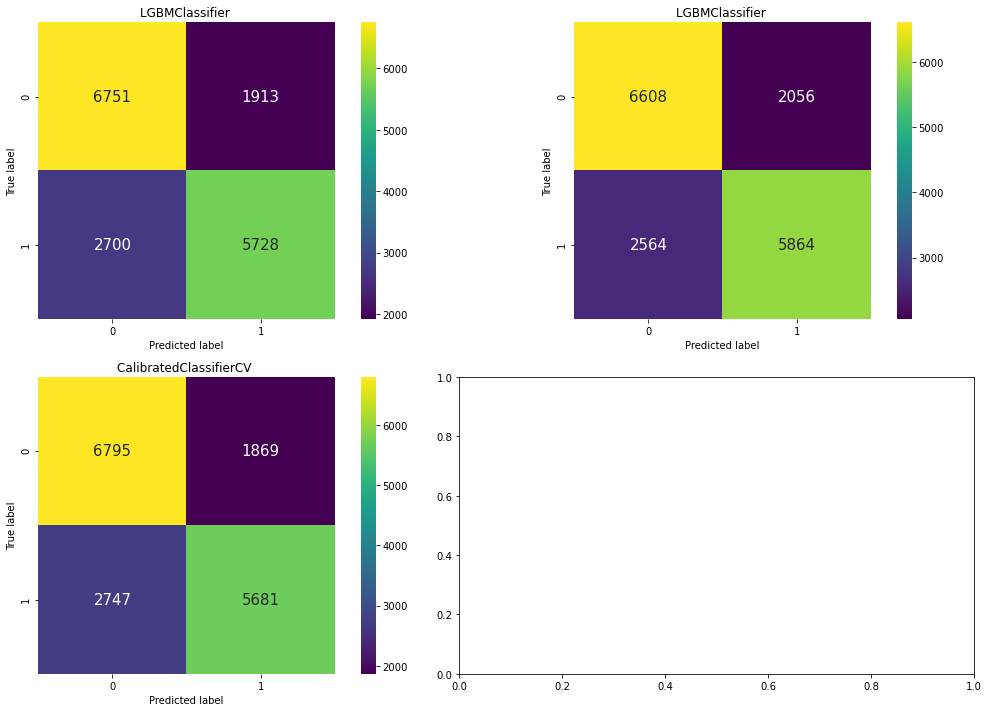

In [72]:
# creating a list with the LGBM models
models = [lgbm, lgbm_tuned, lgbm_tuned_calibrated]

#set threshold value
thresh = 0.50

# plotting confusion matrices (2x2) using the helper functions (section 1.3) for each model prediction x model test
plot_multiple_confusion_matrices(2, 2, x_test, y_test, models, thresh)

***
**As seen above:**


- For the 'y_test' array predicting, the LGBM Tuned and the LGBM Default models have the higher Precision value between them all, with Tuned & Calibrated having the highest one, by a slightly difference. Which is important for the business interests.
<br>

- For the 'y_test' array predicting, the LGBM Tuned and the LGBM Default models have the lower False Negative values between them all, with LGBM Tuned having the lowest one, by a significant difference of 136. Which is important for the patient interests.

### <font color=green size= 4>9.1.2 BRIER SCORE LOSS INDICATOR </font>
***

In [73]:
# predicting the probabilities to return class 1 for each one of the LGBM models
lgbm_prob = lgbm.predict_proba(x_test)[:,1]
lgbm_tuned_prob = lgbm_tuned.predict_proba(x_test)[:,1]
lgbm_tuned_calibrated_prob = lgbm_tuned_calibrated.predict_proba(x_test)[:,1]

# calculating the Brier Score Loss indicatior for each one of the LGBM models
lgbm_prob_bsl = brier_score_loss(y_test, lgbm_prob, pos_label= 1)
lgbm_tuned_prob_bsl = brier_score_loss(y_test, lgbm_tuned_prob, pos_label= 1)
lgbm_tuned_calibrated_bsl = brier_score_loss(y_test, lgbm_tuned_calibrated_prob, pos_label= 1)

# printing the Brier Score Loss indicatior calculated value for each one of the LGBM models 
print("LGBM - Brier Score loss: {}".format(lgbm_prob_bsl))
print("LGBM tuned - Brier Score loss: {}".format(lgbm_tuned_prob_bsl))
print("LGBM tuned & calibrated - Brier Score loss: {}".format(lgbm_tuned_calibrated_bsl))

LGBM - Brier Score loss: 0.18553399210350302
LGBM tuned - Brier Score loss: 0.18494138422990927
LGBM tuned & calibrated - Brier Score loss: 0.18303980648136509


***
- The Brier Score Loss measures the mean squared difference between the predicted probability and the actual outcome
- The Brier Score Loss fits analysis with categorical or binary outcomes. This is because the Brier Score Loss assumes that all possible outcomes are equivalently “distant” from one another. 
- The smaller the Brier score loss, the better. 

**As seen above:**

All models have the save Brier Score Loss value, approximately. With the LGBM Tuned & Calibrated model having the lowest one, by a slightly difference.

### <font color=green size= 4>9.1.3 ROC CURVE INDICATOR </font>
***

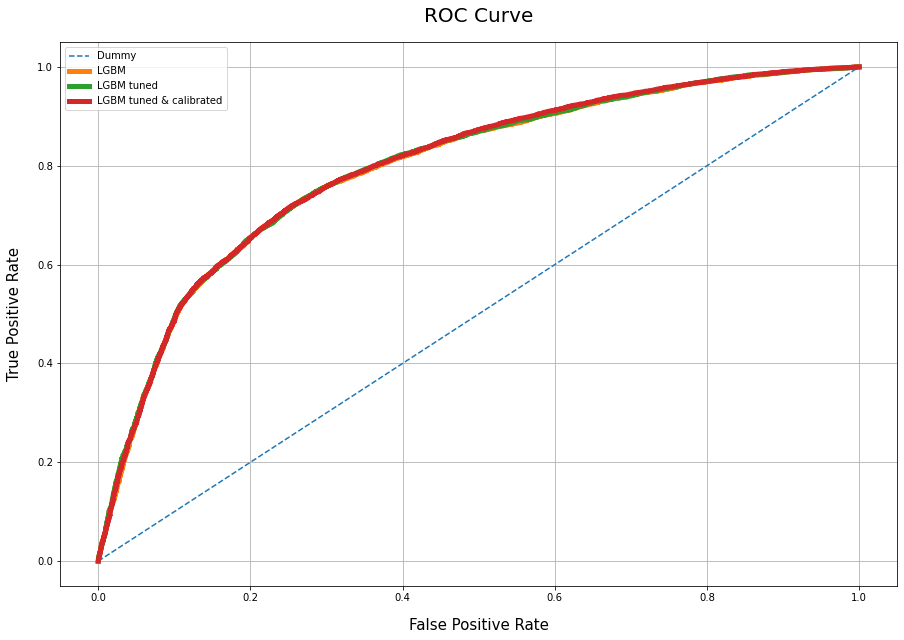

In [74]:
# creating a figure with 1 rows and 1 columns of axes
plt.figure(figsize=(15,10))

# creating a list/array as a dummy classifier with the same size as 'y_test' array. Predicting all outcomes as class 0
dummy_probs = [0 for _ in range(len(y_test))]

# calculating the false posite rate and true positive rate by comparing 'y_test' and 'dummy_probs' array
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, dummy_probs)

# calculating the false posite rate and true positive rate for each one of the best models, by comparing 'y_test' and model probs array
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_prob)
lgbm_tuned_fpr, lgbm_tuned_tpr, _ = roc_curve(y_test, lgbm_tuned_prob)
lgbm_tuned_calibrated_fpr, lgbm_tuned_calibrated_tpr, _ = roc_curve(y_test, lgbm_tuned_calibrated_prob)

# plotting the roc curve for each one of the best models
plt.plot(dummy_fpr, dummy_tpr, linestyle= '--', label= 'Dummy')
plt.plot(lgbm_fpr, lgbm_tpr, linestyle= '-', linewidth= 5 , label= 'LGBM')
plt.plot(lgbm_tuned_fpr, lgbm_tuned_tpr, linestyle= '-', linewidth= 5 , label= 'LGBM tuned')
plt.plot(lgbm_tuned_calibrated_fpr, lgbm_tuned_calibrated_tpr, linestyle= '-', linewidth= 5 , label= 'LGBM tuned & calibrated')

# setting figure title, labels and grid
plt.title("ROC Curve", fontsize=20, pad = 20)
plt.xlabel('False Positive Rate', size= 15, labelpad= 15)
plt.ylabel('True Positive Rate', size= 15, labelpad= 15)
plt.grid()

# displaying the graph legend
plt.legend()

# displaying the figure
plt.show()

***
**As seen above:**

For all LGBM models, the behavior is almost the same. With some points the Tuned & Calibrated surpassing the others.

## <font color=green size= 5>9.2 FINAL METRICS CLASSIFICATION REPORT </font>
***

In [75]:
# creating a dictionary with the LGBM model metrics
dict_lgbm = {'Algorithm': 'LGBM Classifier', 
            'Precision': f'{round(cv_scores_precision.mean(), 4)}% (+/-{round(cv_scores_precision.std(), 4)}%)',
            'Recall': f'{round(cv_scores_recall.mean(), 4)}% (+/-{round(cv_scores_recall.std(), 4)}%)',
            'F1_score': f'{round(cv_scores_f1_score.mean(), 4)}% (+/-{round(cv_scores_f1_score.std(), 4)}%)',
            'Accuracy': f'{round(cv_scores_accuracy.mean(), 4)}% (+/-{round(cv_scores_accuracy.std(), 4)}%)'}

# creating a dictionary with the LGBM tuned model metrics
dict_lgbm_tuned = {'Algorithm': 'LGBM Classifier Tuned', 
            'Precision': f'{round(cv_scores_precision_tuned.mean(), 4)}% (+/-{round(cv_scores_precision_tuned.std(), 4)}%)',
            'Recall': f'{round(cv_scores_recall_tuned.mean(), 4)}% (+/-{round(cv_scores_recall_tuned.std(), 4)}%)',
            'F1_score': f'{round(cv_scores_f1_score_tuned.mean(), 4)}% (+/-{round(cv_scores_f1_score_tuned.std(), 4)}%)',
            'Accuracy': f'{round(cv_scores_accuracy_tuned.mean(), 4)}% (+/-{round(cv_scores_accuracy_tuned.std(), 4)}%)'}

# creating a dictionary with the LGBM tuned and calibrated model metrics
dict_lgbm_tuned_calibrated = {'Algorithm': 'LGBM Classifier Tuned & Calibrated', 
            'Precision': f'{round(cv_scores_precision_tuned_calibrated.mean(), 4)}% (+/-{round(cv_scores_precision_tuned_calibrated.std(), 4)}%)',
            'Recall': f'{round(cv_scores_recall_tuned_calibrated.mean(), 4)}% (+/-{round(cv_scores_recall_tuned_calibrated.std(), 4)}%)',
            'F1_score': f'{round(cv_scores_f1_score_tuned_calibrated.mean(), 4)}% (+/-{round(cv_scores_f1_score_tuned_calibrated.std(), 4)}%)',
            'Accuracy': f'{round(cv_scores_accuracy_tuned_calibrated.mean(), 4)}% (+/-{round(cv_scores_accuracy_tuned_calibrated.std(), 4)}%)'}

In [76]:
# modifying the dictionaries to the pandas can transform it into a dataset
dict_lgbm = {k:[v] for k,v in dict_lgbm.items()}
dict_lgbm_tuned = {k:[v] for k,v in dict_lgbm_tuned.items()}
dict_lgbm_tuned_calibrated = {k:[v] for k,v in dict_lgbm_tuned_calibrated.items()}

# creating each model metrics dataset
df_lgbm = pd.DataFrame(dict_lgbm)
df_lgbm_tuned = pd.DataFrame(dict_lgbm_tuned)
df_lgbm_tuned_calibrated = pd.DataFrame(dict_lgbm_tuned_calibrated)

# combining the metrics datasets into a dataset to compare
df_models_comparision = pd.concat([df_lgbm, df_lgbm_tuned, df_lgbm_tuned_calibrated])

# returning the dataset
df_models_comparision

,Algorithm,Precision,Recall,F1_score,Accuracy
0,LGBM Classifier,74.9038% (+/-0.4051%),68.5601% (+/-0.4849%),71.5901% (+/-0.3005%),73.1687% (+/-0.272%)
0,LGBM Classifier Tuned,74.3488% (+/-0.5091%),69.628% (+/-0.7112%),71.9071% (+/-0.3361%),73.1746% (+/-0.2853%)
0,LGBM Classifier Tuned & Calibrated,74.756% (+/-0.2976%),68.925% (+/-0.687%),71.7212% (+/-0.4839%),73.2009% (+/-0.3806%)


***
**As seen above:**

- All LGBM models have almost the same metrics, in general
<br>

- Taking in account that the LGBM Tuned model have a considerable Precision Deviation that, is the best case, will not predict with a precision higher than 75%, which is a turning point to increase by R$ 500 the test price. So it will be cut out
<br>

- Taking in account that the LGBM Default model have a lower Recall and lower F1 score than the LGBM Tuned & Calibrated model, it will be cut out, thinking about the patients interests

So, we will choose the LGBM Tuned & Calibrated as the final model to propose.

# <font color=green size= 6> <b>10. BUSINESS PERFORMANCE </font></b>
***

In [77]:
# setting the general information
test_cost = 1000
baseline  = 50
price_per_percent_over_baseline = 500/5



# ACTUAL CDD COMPANY BUSINESS PERFORMANCE

# setting the actual accuracies
actual_precision_min = 55
actual_precision_max = 65

# setting the actual lower and higher precisions
actual_percent_difference_min = actual_precision_min - baseline
actual_percent_difference_max = actual_precision_max - baseline

# setting tha actual differences from the lower and higher precisions and baseline accuracy
actual_worst_profit = actual_percent_difference_min  * price_per_percent_over_baseline - test_cost
actual_best_profit  = actual_percent_difference_max * price_per_percent_over_baseline - test_cost

# priting the actual business scenario's informations
print('Actual business model perfomance profit for a unique test diagnosis:')
print(f' Worst case:  R$ {round(actual_worst_profit, 2):,.2f}')
print(f' Best case:   R$ {round(actual_best_profit, 2):,.2f}')



# PROPOSED CDD COMPANY BUSINESS PERFORMANCE

# setting the model averange precision
model_precision = 74.7560 / 100

# setting the model precision deviation
model_precision_deviation = 0.2976 / 100

# setting the proposed lower and higher precisions
proposed_precision_min = (model_precision - model_precision_deviation) * 100
proposed_precision_max = (model_precision + model_precision_deviation) * 100

# setting tha proposed differences from the lower and higher accuracies and baseline precisions
proposed_percent_difference_min = proposed_precision_min - baseline
proposed_percent_difference_max = proposed_precision_max - baseline

proposed_worst_profit = int(proposed_percent_difference_min/ 5) * 5 * price_per_percent_over_baseline
proposed_best_profit  = int(proposed_percent_difference_max/ 5) * 5 * price_per_percent_over_baseline

# priting the proposed business scenario's informations
print('\nProposed business model perfomance profit for a unique test diagnosis:')
print(f' Worst case: R$ {round(proposed_worst_profit, 2):,.2f}')
print(f' Best case:  R$ {round(proposed_best_profit, 2):,.2f}')

Actual business model perfomance profit for a unique test diagnosis:
 Worst case:  R$ -500.00
 Best case:   R$ 500.00

Proposed business model perfomance profit for a unique test diagnosis:
 Worst case: R$ 2,000.00
 Best case:  R$ 2,500.00


# <font color=green size= 6> <b>11. DEPLOY </font></b>
***

## <font color=green size= 5>11.1 DATA CLASS MANIPULATION</font>
***

In [ ]:
import pandas as pd
import numpy as np
import json
import pickle
import inflection

class Cardio_Catch_Diseases(object):

    def __init__(self):
        
        self.age_scaler                  = pickle.load(open('parameters/age_scaler.pkl', 'rb'))
        self.bmi_scaler                  = pickle.load(open('parameters/bmi_scaler.pkl', 'rb'))
        self.weight_scaler               = pickle.load(open('parameters/weight_scaler.pkl', 'rb'))        
        self.high_pressure_scaler        = pickle.load(open('parameters/high_pressure_scaler.pkl', 'rb'))
        self.low_pressure_scaler         = pickle.load(open('parameters/low_pressure_scaler.pkl', 'rb'))
        self.manual_selected_features    = pickle.load(open('parameters/manual_selected_features.pkl', 'rb'))


    def features_engineering(self, df):

        '''creating and transforming datset's features'''

        # creating the dataset's new columns names
        new_columns = ['id', 'age', 'gender', 'height', 'weight', 'high_pressure', 'low_pressure', 'cholesterol', 'glucose', 'smoker', 'alcohol', 'active', 'cardio_disease']

        # changing the dataset's columns names for the 'new_columns' list values       
        df.columns = new_columns

        # creating an array with the height column values in meters
        height_cm = df['height'].values / 100

        # creating a new dataframe column with the Body Mass Index value
        df['BMI'] = df['weight'].values / height_cm**2  

        # modifying the 'age' column values for years, instead of days
        df['age'] = round(df['age']/365, ndigits= 0).astype(int)
        
        return df


    def data_preparation(self, df):

        ''' preparing the dataset's features '''

        # rescaling numerical features
        df['age']            = self.age_scaler.transform(df[['age']].values)
        df['BMI']            = self.bmi_scaler.transform(df[['BMI']].values)
        df['weight']         = self.weight_scaler.transform(df[['weight']].values)
        df['high_pressure']  = self.high_pressure_scaler.transform(df[['high_pressure']].values)
        df['low_pressure']   = self.low_pressure_scaler.transform(df[['low_pressure']].values)
        
        return df     


    def get_predict(self, model, df):

        ''' Filtering the features that will be used to predict and predict '''
        
        # selecting only the features that will be used to predict the result
        selected_features = self.manual_selected_features

        df_copy = df[selected_features].copy()

        # getting prediction
        df_copy['predict'] = model.predict(df_copy)

        # manipulating the return
        if df_copy['predict'][0] == 1:
            df_copy['answer'] = 'High probability of cardiovascular diseases'
        if df_copy['predict'][0] == 0:
            df_copy['answer'] = 'Low probability of cardiovascular diseases'
    
        return df_copy['answer'].to_json(orient= 'records')

## <font color=green size= 5>11.2 API </font>
***

In [ ]:
import pickle
import pandas as pd
import numpy as np
from flask import Flask, request, Response
from classes.cardio_catch_diseases import Cardio_Catch_Diseases
import json

# loading model trained from pickle file
with open('models/lgbm_model_tuned.pkl', 'rb') as file:
    model = pickle.load(file)

# initializing API
app = Flask(__name__)

@app.route('/predict', methods= ['POST'])
def disease_predict():
  
    test_json = request.get_json()

    if test_json:

        # Unique Example
        if isinstance(test_json, dict):            
            test_raw = pd.DataFrame(test_json, index=[0])

        # multiple Example
        else:  # multiple Example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

            
        # instantiating CDD class
        pipeline = Cardio_Catch_Diseases()

        # manipulating features
        test_raw_features = pipeline.features_engineering(test_raw)

        # rescaling features to predict
        test_raw_prepared = pipeline.data_preparation(test_raw_features)

        # predicting
        df_response = pipeline.get_predict(model, test_raw_prepared)

        return df_response

    else:

        return Response("{}", status=200, mimetype= 'application/json')


if __name__ == '__main__':
    app.run(host= '10.0.0.33', port= '5000')

## <font color=green size= 5>11.3 API TESTER </font>
***

In [78]:
# choosing an aleatory patient
df_test = df_raw.sample()

# converting dataset to json
sample = json.dumps(df_test.to_dict( orient='records'))

sample

'[{"id": 24879, "age": 19025, "gender": 1, "height": 184, "weight": 70.0, "ap_hi": 140, "ap_lo": 100, "cholesterol": 1, "gluc": 1, "smoke": 0, "alco": 0, "active": 1, "cardio": 0}]'

In [79]:
# setting url to post the data
url = 'http://10.0.0.33:5000/predict'

# setting the content type
header = {'Content-type': 'application/json'}

# setting data as the sample 
data = sample

# sending a request to API
r = requests.post(url, data= data, headers= header)

# printing request output
print(r.text)

# printing request status code
print(" Status Code {}".format(r.status_code))

["High probability of cardiovascular diseases"]
 Status Code 200
